## <a id='toc1_1_'></a>[Тестовое задание для компании ST LUCE](#toc0_)

Цель задания - сделать/предложить формат дашборда с показателями анализа продаж.

Этапы выполнения отчета:

1. Загрузка данных, проверка содержания на дубликаты, пропуски и соответсвие форматов.
    - Данные, где есть цифровые значения, необходимо проверить на наличие выбросов.
    - Исправление структурных ошибок: все категориальные признаки будут приведены к нижнему регистру.
2. Статистический анализ и построение графиков:
    - Рассчет продаж за указанный период с графиками (общая выручка, средняя сумма заказа, среднее количество заказов на клиента).
    - Определение лучших клиентов (десятка лидеров).
    - Распределение выручки по бизнес-регионам партнеров.
    - Количество продаж по типам запасов или услугам.
    - Анализ на наличие лишних полей (не несущих информацию) и случаев мультиколлинеарности, чтобы избежать проблемы переобучения модели машинного обучения.
3. Выделение тестовой таблицы в размере 25% от общей. Валидационной выборки в данном проекте не будет, так как настройка и обучение будет происходить при помощи кросс-валидации.
4. Построение и настройка гиперпараметров моделей машинного обучения. Поиск наилучшей модели с метрикой RMSE.
5. Проверка лучшей модели на тестовой выборке. Выгрузка результатов в Excel-файл.
6. Общая цель проекта - прогноз продаж на основе полученного периода.

**Содержание отчета**<a id='toc0_'></a>    
- [Тестовое задание для компании ST LUCE](#toc1_1_)    
    - [Загрузка входящих данных](#toc1_1_1_)    
    - [Предварительный анализ полученных данных](#toc1_1_2_)    
    - [Анализ столбцов](#toc1_1_3_)    
      - [Столбец Регистратор.Номер](#toc1_1_3_1_)    
      - [Столбец Регистратор.Дата](#toc1_1_3_2_)    
      - [Столбец Заказ клиента.Дата](#toc1_1_3_3_)    
      - [Столбец Заказ клиента.Номер](#toc1_1_3_4_)    
      - [Столбцы](#toc1_1_3_5_)    
      - [Столбец Аналитика учета по партнерам.Партнер.Отрасль](#toc1_1_3_6_)    
      - [Столбец Количество](#toc1_1_3_7_)    
      - [Столбец Сумма выручки с НДС](#toc1_1_3_8_)    
      - [Столбец Сумма дополнительных расходов](#toc1_1_3_9_)    
    - [Дубликаты](#toc1_1_4_)    
    - [Проверка обработки данных](#toc1_1_5_)    
      - [Выводы по обработке данных:](#toc1_1_5_1_)    
  - [Исследовательский анализ данных](#toc1_2_)    
    - [Выводы по статистическому анализу](#toc1_2_1_)    
    - [Мультиколлинеарность](#toc1_2_2_)    
  - [Обучение моделей](#toc1_3_)    
    - [Разбивка датасетов на тренировочную и тестовую выборки](#toc1_3_1_)    
    - [Построение моделей](#toc1_3_2_)    
      - [Линейная регрессия](#toc1_3_2_1_)    
      - [Случайный лес](#toc1_3_2_2_)    
      - [Категориальный бустинг](#toc1_3_2_3_)    
      - [LightGBM](#toc1_3_2_4_)    
    - [Тестирование модели](#toc1_3_3_)    
      - [CatBoostRegressor](#toc1_3_3_1_)    
  - [Вывод](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# загрузим необходимые в работе модули
from IPython.display import display, HTML

display(HTML(""))

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as skl
import os
from scipy import stats
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    make_scorer,
)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.dummy import DummyRegressor
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, accuracy_score
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

import phik
from phik.report import plot_correlation_matrix
from phik import report


from catboost import Pool, cv
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor


import warnings

warnings.filterwarnings("ignore")

In [2]:
# Первоначально напишем код, который будет отменять перенос выводимых таблиц
pd.set_option("display.expand_frame_repr", False)

In [3]:
# Назначим константу для random_state
RANDOM_STATE = 42


### <a id='toc1_1_1_'></a>[Загрузка входящих данных](#toc0_)

In [4]:
df = pd.read_excel("Для аналитика (1) (1).xlsx")

In [5]:
# Проверим как загрузились данные и выведем первые 5 строк
df.head()


,Регистратор.Номер,Регистратор.Дата,Заказ клиента.Дата,Заказ клиента.Номер,Партнер.Код,Номенклатура.Код,Аналитика учета по партнерам.Партнер.Бизнес-регион,Аналитика учета по партнерам.Партнер.Отрасль,Тип запасов или услуга,Хозяйственная операция,Аналитика учета по партнерам.Контрагент.St федеральный округ,Аналитика учета номенклатуры.Номенклатура.Группа,Аналитика учета по партнерам.Партнер.Основной менеджер,Количество,Сумма выручки с НДС,Сумма выручки без НДС,Сумма дополнительных расходов,Сумма дополнительных расходов без НДС
0,СО-0401-001,01.04.2021 0:00:00,29.03.2021 13:52:30,СО-0329-063,УТ-УТ000297,УТ-00002777,Москва(дубль),Интернет-магазин,Собственный товар,Реализация,Москва,Плафоны ST-LUCE,1_2 Сегодина Светлана,1.0,139.5000,116.2500,NaN,NaN
1,00УТ-002196,01.04.2021 0:00:02,31.03.2021 9:08:37,00УТ-010063,УТ-УТ000889,УТ-00018083,Самарская,NaN,Собственный товар,Реализация,Приволжский федеральный округ,Плафоны ST-LUCE,4_Баранов Михаил,1.0,0.0093,0.0093,NaN,NaN
2,00УТ-002199,01.04.2021 0:00:03,31.03.2021 10:41:16,00УТ-010067,00000078,00-00011710,Москва(дубль),Свет магазин (специализированная розница),Работа (Услуга),Реализация,Москва,Услуги,Тимченко Максим,1.0,465.0000,387.5031,NaN,NaN
3,00УТ-002200,01.04.2021 0:00:04,29.03.2021 8:18:02,00УТ-009981,00000078,00019104,Москва(дубль),Свет магазин (специализированная розница),Собственный товар,Реализация,Москва,ST LUCE Decorative,Тимченко Максим,2.0,6091.5000,5076.2469,NaN,NaN
4,СО-0401-002,01.04.2021 0:00:05,30.03.2021 15:08:12,СО-0330-053,УТ-УТ002337,00018885,Москва(дубль),Комплектовщик,Собственный товар,Реализация,Москва,EVOLUCE Актуальный ассортимент,Тимченко Максим,1.0,3966.4500,3305.3781,NaN,NaN


In [6]:
# Выведем общие данные по датафрейму

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 18 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Регистратор.Номер                                             9240 non-null   object 
 1   Регистратор.Дата                                              9240 non-null   object 
 2   Заказ клиента.Дата                                            8068 non-null   object 
 3   Заказ клиента.Номер                                           8068 non-null   object 
 4   Партнер.Код                                                   9240 non-null   object 
 5   Номенклатура.Код                                              9240 non-null   object 
 6   Аналитика учета по партнерам.Партнер.Бизнес-регион            9240 non-null   object 
 7   Аналитика учета по партнерам.Партнер.Отрасль                  4891 no

Таблица состоит из 9240 строк и 18 колонок. Большинство данных имеют категориальный тип, цифровые значения имеют тип с плавающей точкой, которые нужно будет привести к целому числу для экономии места на диске и ускорения работы моделей.

Есть пропуски в столбцах:

- Заказ клиента.Дата,
- Заказ клиента.Номер,
- Аналитика учета по партнерам.Партнер.Отрасль,
- Аналитика учета по партнерам.Контрагент.St федеральный округ,
- Количество,
- Сумма дополнительных расходов,
- Сумма дополнительных расходов без НДС

Столбцы с указанием суммы без НДС будет необходимо удалить из отчета, так как они не будут участвовать в анализе.

In [7]:
# Выведем общие статистические значения для полученных данных

print(df.describe(include="all").T)

                                                     count unique                    top  freq         mean           std        min       25%        50%         75%        max
Регистратор.Номер                                     9240   2852            СМ-0430-001   218          NaN           NaN        NaN       NaN        NaN         NaN        NaN
Регистратор.Дата                                      9240   2933    30.04.2021 23:59:59  1312          NaN           NaN        NaN       NaN        NaN         NaN        NaN
Заказ клиента.Дата                                    8068   3133     12.04.2021 0:00:00    78          NaN           NaN        NaN       NaN        NaN         NaN        NaN
Заказ клиента.Номер                                   8068   3202            ЭЛ-0426-102    58          NaN           NaN        NaN       NaN        NaN         NaN        NaN
Партнер.Код                                           9240    542            00-00000015   522          NaN        

### <a id='toc1_1_2_'></a>[Предварительный анализ полученных данных](#toc0_)

- Всего реализаций - 2852,
- Всего заказов - 3202,
- Всего партнеров - 542,
- Количество уникальных товаров - 2635,
- Всего регионов - 68,
- Количество отраслей (способ продажи) - 11,
- Количество федеральных округов - 18, (по сути дубль для регионов, необходимо удалить),
- Номеклатурные группы - 67,
- Менеджеры компаний - 12,
- Средняя сумма выручки с НДС - 6478.63, медиана выручки - 4087.35, максимальная сумма выручки за одну реализацию - 288463.68. Различие между медианой и средним значением по выручке указывает на наличие выбросов.

In [8]:
# Удалим обозначеные столбцы (столбцы без НДС и поле с наименованием федеральныго округа)

df = df.drop(
    [
        "Аналитика учета по партнерам.Контрагент.St федеральный округ",
        "Сумма выручки без НДС",
        "Сумма дополнительных расходов без НДС",
    ],
    axis=1,
)

# Проверим работу кода

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 15 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Регистратор.Номер                                       9240 non-null   object 
 1   Регистратор.Дата                                        9240 non-null   object 
 2   Заказ клиента.Дата                                      8068 non-null   object 
 3   Заказ клиента.Номер                                     8068 non-null   object 
 4   Партнер.Код                                             9240 non-null   object 
 5   Номенклатура.Код                                        9240 non-null   object 
 6   Аналитика учета по партнерам.Партнер.Бизнес-регион      9240 non-null   object 
 7   Аналитика учета по партнерам.Партнер.Отрасль            4891 non-null   object 
 8   Тип запасов или услуга                

### <a id='toc1_1_3_'></a>[Анализ столбцов](#toc0_)

#### <a id='toc1_1_3_1_'></a>[Столбец Регистратор.Номер](#toc0_)

In [9]:
# Выведем количество реализаций
print("Количество уникальных реализаций", df["Регистратор.Номер"].nunique())

# Выведем часть столбца
print(df["Регистратор.Номер"].head())

Количество уникальных реализаций 2852
0    СО-0401-001
1    00УТ-002196
2    00УТ-002199
3    00УТ-002200
4    СО-0401-002
Name: Регистратор.Номер, dtype: object


Всего 2852 реализации, понизим регистр чтобы избежать ошибки, если часть реализаций были записаны с маленькими буквами.

In [10]:
# Понизим регистр в столбце Регистратор.Номер
df["Регистратор.Номер"] = df["Регистратор.Номер"].str.lower()

# Проверим работу кода
print(df["Регистратор.Номер"].head())

0    со-0401-001
1    00ут-002196
2    00ут-002199
3    00ут-002200
4    со-0401-002
Name: Регистратор.Номер, dtype: object


#### <a id='toc1_1_3_2_'></a>[Столбец Регистратор.Дата](#toc0_)

In [11]:
# Выведем даты реализаций
print("Количество дат реализаций", df["Регистратор.Дата"].nunique())

# Выведем часть столбца
print(df["Регистратор.Дата"].head())

Количество дат реализаций 2933
0    01.04.2021 0:00:00
1    01.04.2021 0:00:02
2    01.04.2021 0:00:03
3    01.04.2021 0:00:04
4    01.04.2021 0:00:05
Name: Регистратор.Дата, dtype: object


Для реализаций есть 2933 даты, формат нужно привести к формату даты.

In [12]:
# Преобразование столбца 'Регистратор.Дата' в формат datetime с сохранением только даты
df["Регистратор.Дата"] = pd.to_datetime(
    df["Регистратор.Дата"], format="%d.%m.%Y %H:%M:%S"
).dt.strftime("%d-%m-%Y")


# Проверим работу кода
print(df["Регистратор.Дата"].head())
print(df["Регистратор.Дата"].info())

# Рассматриваемый период времени
print("Период времени реализаций:")
print(df["Регистратор.Дата"].min())
print(df["Регистратор.Дата"].max())

0    01-04-2021
1    01-04-2021
2    01-04-2021
3    01-04-2021
4    01-04-2021
Name: Регистратор.Дата, dtype: object
<class 'pandas.core.series.Series'>
RangeIndex: 9240 entries, 0 to 9239
Series name: Регистратор.Дата
Non-Null Count  Dtype 
--------------  ----- 
9240 non-null   object
dtypes: object(1)
memory usage: 72.3+ KB
None
Период времени реализаций:
01-04-2021
30-04-2021


#### <a id='toc1_1_3_3_'></a>[Столбец Заказ клиента.Дата](#toc0_)

In [13]:
# Выведем даты заказов
print("Количество дат заказов", df["Заказ клиента.Дата"].nunique())

# Выведем часть столбца
print(df["Заказ клиента.Дата"].head())

Количество дат заказов 3133
0    29.03.2021 13:52:30
1     31.03.2021 9:08:37
2    31.03.2021 10:41:16
3     29.03.2021 8:18:02
4    30.03.2021 15:08:12
Name: Заказ клиента.Дата, dtype: object


Для заказов есть 3133 даты, формат нужно привести к формату даты, как мы это сделали для дат реализаций.

В столбце Заказ клиента.Дата есть пропуски, выведем строки с пропусками.

In [14]:
display(df[df["Заказ клиента.Дата"].isna()].head(10))

,Регистратор.Номер,Регистратор.Дата,Заказ клиента.Дата,Заказ клиента.Номер,Партнер.Код,Номенклатура.Код,Аналитика учета по партнерам.Партнер.Бизнес-регион,Аналитика учета по партнерам.Партнер.Отрасль,Тип запасов или услуга,Хозяйственная операция,Аналитика учета номенклатуры.Номенклатура.Группа,Аналитика учета по партнерам.Партнер.Основной менеджер,Количество,Сумма выручки с НДС,Сумма дополнительных расходов
1400,су-0407-001,07-04-2021,NaN,NaN,УТ-УТ001659,00015635,Санкт-Петербург,NaN,Собственный товар,Оприходование по возврату,Архив,2_Сабинин Виктор Васильевич,-1.0,-11978.4465,NaN
2708,су-0412-001,12-04-2021,NaN,NaN,УТ-УТ000751,00020459,Краснодарский,NaN,Собственный товар,Отчет комиссионера,EVOLED Новинки,3_Акопян Артур,1.0,8900.1000,4402.2
3135,эл-0413-001,13-04-2021,NaN,NaN,УТ-УТ002837,00018722,Москва(дубль),NaN,Собственный товар,Отчет комиссионера,EVOLUCE Актуальный ассортимент,Филиппова Оксана,1.0,6603.0000,3195.0
3449,со-0414-002,14-04-2021,NaN,NaN,00000167,00013401,Татарстан,NaN,Собственный товар,Возврат товаров от клиента прошлых периодов,Архив,4_Баранов Михаил,NaN,0.0000,NaN
4095,эл-0416-001,16-04-2021,NaN,NaN,ЦБ-00001405,00006346,Крым,NaN,Собственный товар,Отчет комиссионера,ST LUCE Decorative,3_Акопян Артур,1.0,22869.6300,9222.0
4096,эл-0416-001,16-04-2021,NaN,NaN,ЦБ-00001405,00017588,Крым,NaN,Собственный товар,Отчет комиссионера,ST LUCE РАСПРОДАЖА,3_Акопян Артур,2.0,6496.9800,2620.0
4097,эл-0416-001,16-04-2021,NaN,NaN,ЦБ-00001405,ЦБ-00018500,Крым,NaN,Собственный товар,Отчет комиссионера,Архив,3_Акопян Артур,1.0,1442.4300,582.0
4098,эл-0416-001,16-04-2021,NaN,NaN,ЦБ-00001405,00015312,Крым,NaN,Собственный товар,Отчет комиссионера,ST LUCE РАСПРОДАЖА,3_Акопян Артур,2.0,14937.6600,6024.0
4099,эл-0416-001,16-04-2021,NaN,NaN,ЦБ-00001405,00015313,Крым,NaN,Собственный товар,Отчет комиссионера,Архив,3_Акопян Артур,1.0,12337.3800,4975.0
4100,эл-0416-001,16-04-2021,NaN,NaN,ЦБ-00001405,ЦБ-00018002,Крым,NaN,Собственный товар,Отчет комиссионера,Архив,3_Акопян Артур,1.0,18921.7800,7630.0


Заменим пропуски в столбце Заказ клиента.Дата на дату первой реализации в датасете, равной 01-04-2021.

In [15]:
# Замена пропусков в столбце "Заказ клиента.Дата" на указанную дату
df["Заказ клиента.Дата"].fillna("01.04.2021 00:00:00", inplace=True)

# Проверим работу кода
display(df[df["Заказ клиента.Дата"].isna()].head(10))

,Регистратор.Номер,Регистратор.Дата,Заказ клиента.Дата,Заказ клиента.Номер,Партнер.Код,Номенклатура.Код,Аналитика учета по партнерам.Партнер.Бизнес-регион,Аналитика учета по партнерам.Партнер.Отрасль,Тип запасов или услуга,Хозяйственная операция,Аналитика учета номенклатуры.Номенклатура.Группа,Аналитика учета по партнерам.Партнер.Основной менеджер,Количество,Сумма выручки с НДС,Сумма дополнительных расходов


In [16]:
df["Заказ клиента.Дата"].unique()


array(['29.03.2021 13:52:30', '31.03.2021 9:08:37', '31.03.2021 10:41:16',
       ..., '28.04.2021 22:19:35', '24.02.2021 10:54:10',
       '29.04.2021 23:42:52'], dtype=object)

Все пропуски в датах заказов были удалены.

In [17]:
# Преобразование столбца 'Заказ клиента.Дата' в формат datetime с сохранением только даты
df["Заказ клиента.Дата"] = pd.to_datetime(
    df["Заказ клиента.Дата"], format="%d.%m.%Y %H:%M:%S"
).dt.strftime("%d-%m-%Y")


# Проверим работу кода
print(df["Заказ клиента.Дата"].head())
print(df["Заказ клиента.Дата"].info())

# Рассматриваемый период времени
print("Период времени заказов:")
print(df["Заказ клиента.Дата"].min())
print(df["Заказ клиента.Дата"].max())

0    29-03-2021
1    31-03-2021
2    31-03-2021
3    29-03-2021
4    30-03-2021
Name: Заказ клиента.Дата, dtype: object
<class 'pandas.core.series.Series'>
RangeIndex: 9240 entries, 0 to 9239
Series name: Заказ клиента.Дата
Non-Null Count  Dtype 
--------------  ----- 
9240 non-null   object
dtypes: object(1)
memory usage: 72.3+ KB
None
Период времени заказов:
01-02-2021
31-08-2020


#### <a id='toc1_1_3_4_'></a>[Столбец Заказ клиента.Номер](#toc0_)

In [18]:
# Выведем количество заказов
print("Количество уникальных заказов", df["Заказ клиента.Номер"].nunique())

# Выведем часть столбца
print(df["Заказ клиента.Номер"].head())

Количество уникальных заказов 3202
0    СО-0329-063
1    00УТ-010063
2    00УТ-010067
3    00УТ-009981
4    СО-0330-053
Name: Заказ клиента.Номер, dtype: object


В столбце Заказ клиента.Номер также произведем понижение регистра.

In [19]:
# Понизим регистр в столбце Регистратор.Номер
df["Заказ клиента.Номер"] = df["Заказ клиента.Номер"].str.lower()

# Проверим работу кода
print(df["Заказ клиента.Номер"].head())

0    со-0329-063
1    00ут-010063
2    00ут-010067
3    00ут-009981
4    со-0330-053
Name: Заказ клиента.Номер, dtype: object


В стобце Заказ клиента.Номер также есть пропуски, но мы не можем использовать метод ближайших соседей, так как это будет заведомой ложью. Заменим пропуски на значение 'unknown'.

In [20]:
# Заменим пропуски на значение unknown
df["Заказ клиента.Номер"].fillna("unknown", inplace=True)

# Проверим работу кода
display(df[df["Заказ клиента.Номер"].isna()].head(10))

,Регистратор.Номер,Регистратор.Дата,Заказ клиента.Дата,Заказ клиента.Номер,Партнер.Код,Номенклатура.Код,Аналитика учета по партнерам.Партнер.Бизнес-регион,Аналитика учета по партнерам.Партнер.Отрасль,Тип запасов или услуга,Хозяйственная операция,Аналитика учета номенклатуры.Номенклатура.Группа,Аналитика учета по партнерам.Партнер.Основной менеджер,Количество,Сумма выручки с НДС,Сумма дополнительных расходов


#### <a id='toc1_1_3_5_'></a>[Столбцы](#toc0_)

- Партнер.Код,
- Номенклатура.Код,
- Аналитика учета по партнерам.Партнер.Бизнес-регион,
- Тип запасов или услуга, Хозяйственная операция,
- Аналитика учета номенклатуры.Номенклатура.Группа,
- Аналитика учета по партнерам.Партнер.Основной менеджер

В этих столбцах нет пропусков, нужно только произвести понижение регистра. 

In [21]:
# Понизим регистр в столбцах
df["Партнер.Код"] = df["Партнер.Код"].str.lower()
df["Номенклатура.Код"] = df["Номенклатура.Код"].str.lower()
df["Аналитика учета по партнерам.Партнер.Бизнес-регион"] = df[
    "Аналитика учета по партнерам.Партнер.Бизнес-регион"
].str.lower()
df["Тип запасов или услуга"] = df["Тип запасов или услуга"].str.lower()
df["Хозяйственная операция"] = df["Хозяйственная операция"].str.lower()
df["Аналитика учета номенклатуры.Номенклатура.Группа"] = df[
    "Аналитика учета номенклатуры.Номенклатура.Группа"
].str.lower()
df["Аналитика учета по партнерам.Партнер.Основной менеджер"] = df[
    "Аналитика учета по партнерам.Партнер.Основной менеджер"
].str.lower()

# Проверим работу кода
display(df.head(10))

,Регистратор.Номер,Регистратор.Дата,Заказ клиента.Дата,Заказ клиента.Номер,Партнер.Код,Номенклатура.Код,Аналитика учета по партнерам.Партнер.Бизнес-регион,Аналитика учета по партнерам.Партнер.Отрасль,Тип запасов или услуга,Хозяйственная операция,Аналитика учета номенклатуры.Номенклатура.Группа,Аналитика учета по партнерам.Партнер.Основной менеджер,Количество,Сумма выручки с НДС,Сумма дополнительных расходов
0,со-0401-001,01-04-2021,29-03-2021,со-0329-063,ут-ут000297,ут-00002777,москва(дубль),Интернет-магазин,собственный товар,реализация,плафоны st-luce,1_2 сегодина светлана,1.0,139.5000,NaN
1,00ут-002196,01-04-2021,31-03-2021,00ут-010063,ут-ут000889,ут-00018083,самарская,NaN,собственный товар,реализация,плафоны st-luce,4_баранов михаил,1.0,0.0093,NaN
2,00ут-002199,01-04-2021,31-03-2021,00ут-010067,00000078,00-00011710,москва(дубль),Свет магазин (специализированная розница),работа (услуга),реализация,услуги,тимченко максим,1.0,465.0000,NaN
3,00ут-002200,01-04-2021,29-03-2021,00ут-009981,00000078,00019104,москва(дубль),Свет магазин (специализированная розница),собственный товар,реализация,st luce decorative,тимченко максим,2.0,6091.5000,NaN
4,со-0401-002,01-04-2021,30-03-2021,со-0330-053,ут-ут002337,00018885,москва(дубль),Комплектовщик,собственный товар,реализация,evoluce актуальный ассортимент,тимченко максим,1.0,3966.4500,NaN
5,со-0401-002,01-04-2021,30-03-2021,со-0330-053,ут-ут002337,00017739,москва(дубль),Комплектовщик,собственный товар,реализация,st luce outdoor,тимченко максим,4.0,8165.4000,NaN
6,со-0401-002,01-04-2021,30-03-2021,со-0330-053,ут-ут002337,00015810,москва(дубль),Комплектовщик,собственный товар,реализация,st luce decorative,тимченко максим,4.0,36735.0000,NaN
7,со-0401-002,01-04-2021,30-03-2021,со-0330-053,ут-ут002337,00015832,москва(дубль),Комплектовщик,собственный товар,реализация,архив,тимченко максим,5.0,6422.8125,NaN
8,со-0401-003,01-04-2021,30-03-2021,со-0330-027,ут-ут002385,00016264,москва(дубль),NaN,собственный товар,реализация,st luce decorative,1_1 щербакова светлана,2.0,7540.4400,NaN
9,эл-0402-001,02-04-2021,30-03-2021,эл-0330-017,ут-00000012,ут-00000978,санкт-петербург,Интернет-магазин,собственный товар,реализация,плафоны st-luce,1_2 сегодина светлана,4.0,558.0000,NaN


#### <a id='toc1_1_3_6_'></a>[Столбец Аналитика учета по партнерам.Партнер.Отрасль](#toc0_)

Заменим пропущенные значения на unknown.

In [22]:
# Заменим пропуски на значение unknown
df["Аналитика учета по партнерам.Партнер.Отрасль"].fillna("unknown", inplace=True)

# Проверим работу кода
display(df[df["Аналитика учета по партнерам.Партнер.Отрасль"].isna()].head(10))

,Регистратор.Номер,Регистратор.Дата,Заказ клиента.Дата,Заказ клиента.Номер,Партнер.Код,Номенклатура.Код,Аналитика учета по партнерам.Партнер.Бизнес-регион,Аналитика учета по партнерам.Партнер.Отрасль,Тип запасов или услуга,Хозяйственная операция,Аналитика учета номенклатуры.Номенклатура.Группа,Аналитика учета по партнерам.Партнер.Основной менеджер,Количество,Сумма выручки с НДС,Сумма дополнительных расходов


#### <a id='toc1_1_3_7_'></a>[Столбец Количество](#toc0_)


In [24]:
# Выведем часть таблицы, где есть пропуски в столбце количество

display(df[df["Количество"].isna()].head(10))

,Регистратор.Номер,Регистратор.Дата,Заказ клиента.Дата,Заказ клиента.Номер,Партнер.Код,Номенклатура.Код,Аналитика учета по партнерам.Партнер.Бизнес-регион,Аналитика учета по партнерам.Партнер.Отрасль,Тип запасов или услуга,Хозяйственная операция,Аналитика учета номенклатуры.Номенклатура.Группа,Аналитика учета по партнерам.Партнер.Основной менеджер,Количество,Сумма выручки с НДС,Сумма дополнительных расходов
113,со-0401-001,01-04-2021,11-03-2021,со-0311-106,ут-ут002639,00018452,московская,unknown,собственный товар,возврат товаров от клиента прошлых периодов,st luce decorative,6_дасаев илья,NaN,0.0,NaN
177,эл-0401-001,01-04-2021,10-02-2021,эл-0210-111,ут-ут000682,00018627,краснодарский,Свет магазин (специализированная розница),собственный товар,возврат товаров от клиента прошлых периодов,st luce decorative,3_акопян артур,NaN,0.0,NaN
229,со-0401-002,01-04-2021,01-12-2020,со-1201-077,00000167,00015805,татарстан,unknown,собственный товар,возврат товаров от клиента прошлых периодов,st luce decorative,4_баранов михаил,NaN,0.0,NaN
266,со-0401-003,01-04-2021,01-03-2021,со-0301-104,ут-ут000297,00017587,москва(дубль),Интернет-магазин,собственный товар,возврат товаров от клиента прошлых периодов,st luce decorative,1_2 сегодина светлана,NaN,0.0,NaN
268,со-0401-004,01-04-2021,02-03-2021,со-0302-089,ут-ут000297,00020738,москва(дубль),Интернет-магазин,собственный товар,возврат товаров от клиента прошлых периодов,evoluce актуальный ассортимент,1_2 сегодина светлана,NaN,0.0,NaN
289,со-0401-005,01-04-2021,15-03-2021,со-0315-103,ут-ут000297,00016569,москва(дубль),Интернет-магазин,собственный товар,возврат товаров от клиента прошлых периодов,markslojd основной ассортимент,1_2 сегодина светлана,NaN,0.0,NaN
347,эл-0402-001,02-04-2021,20-01-2021,эл-0120-061,ут-ут001237,00020847,ставропольский,Свет магазин (специализированная розница),собственный товар,возврат товаров от клиента прошлых периодов,st luce decorative,3_акопян артур,NaN,0.0,NaN
362,эл-0402-002,02-04-2021,17-03-2021,эл-0317-071,00-00000015,00020546,москва(дубль),Интернет-магазин,собственный товар,возврат товаров от клиента прошлых периодов,evoluce актуальный ассортимент,1_2 сегодина светлана,NaN,0.0,NaN
364,эл-0402-003,02-04-2021,09-03-2021,эл-0309-161,00-00000015,00018588,москва(дубль),Интернет-магазин,собственный товар,возврат товаров от клиента прошлых периодов,evoluce актуальный ассортимент,1_2 сегодина светлана,NaN,0.0,NaN
366,эл-0402-003,02-04-2021,24-02-2021,эл-0224-124,00-00000015,00005708,москва(дубль),Интернет-магазин,собственный товар,возврат товаров от клиента прошлых периодов,st luce decorative,1_2 сегодина светлана,NaN,0.0,NaN


Можно обратить внимание, что все строки с неизвестным количеством проданного товара имеют нулевую сумму выручки, что по сути является аномалией. Такие строки необходимо удалить.

In [25]:
# Посчитаем количество пропущенных значений в столбце Количество
print("Всего пропущенных значений в столбце Количество:", df["Количество"].isna().sum())

Всего пропущенных значений в столбце Количество: 317


In [26]:
# Удаление строк с пропусками в столбце 'Количество'
df.dropna(subset=["Количество"], inplace=True)

# Проверим работу кода
print("Всего пропущенных значений в столбце Количество:", df["Количество"].isna().sum())

Всего пропущенных значений в столбце Количество: 0


Также изменим формат данных в столбце Количество на целое число.

In [27]:
# Изменим формат данных
df["Количество"] = df["Количество"].astype("int")

# Проверим работу кода
print(df["Количество"].info())

<class 'pandas.core.series.Series'>
Int64Index: 8923 entries, 0 to 9239
Series name: Количество
Non-Null Count  Dtype
--------------  -----
8923 non-null   int32
dtypes: int32(1)
memory usage: 104.6 KB
None


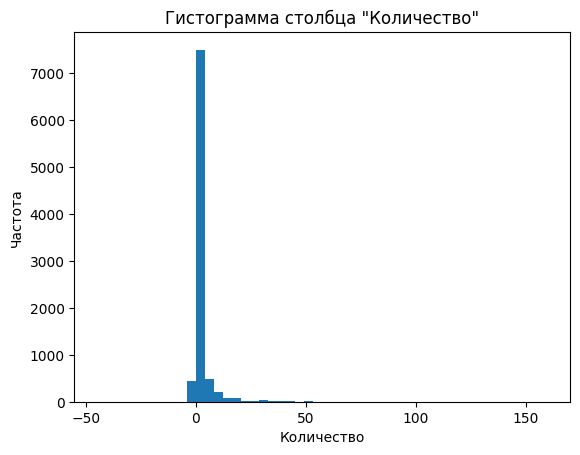

In [28]:
# Проверим столбец Количество на выбросы

plt.hist(df["Количество"], bins=50)
plt.xlabel("Количество")
plt.ylabel("Частота")
plt.title('Гистограмма столбца "Количество"')
plt.show()

Можно отметить, что есть отрицательные значения, что может обозначать возврат или обратную реализацию. Сверхбольших значений не обнаружено, в среднем продается до 3-5 штук товара, судя по графику.

In [29]:
# Выведем статистические данные по столбцу Количество
print(df["Количество"].describe())

count    8923.000000
mean        2.570436
std         5.774847
min       -45.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       160.000000
Name: Количество, dtype: float64


В цифрах мы получили более точную информацию - в среднем продается 2 единицы товары, максимально было возвращено 45 единиц, максимально клиент приобрел 160 единиц одного товара.

#### <a id='toc1_1_3_8_'></a>[Столбец Сумма выручки с НДС](#toc0_)


Пропусков нет, изменим только формат данных на целое число.

In [31]:
# Изменим формат данных
df["Сумма выручки с НДС"] = df["Сумма выручки с НДС"].astype("int")

# Проверим работу кода
print(df["Сумма выручки с НДС"].info())

<class 'pandas.core.series.Series'>
Int64Index: 8923 entries, 0 to 9239
Series name: Сумма выручки с НДС
Non-Null Count  Dtype
--------------  -----
8923 non-null   int32
dtypes: int32(1)
memory usage: 104.6 KB
None


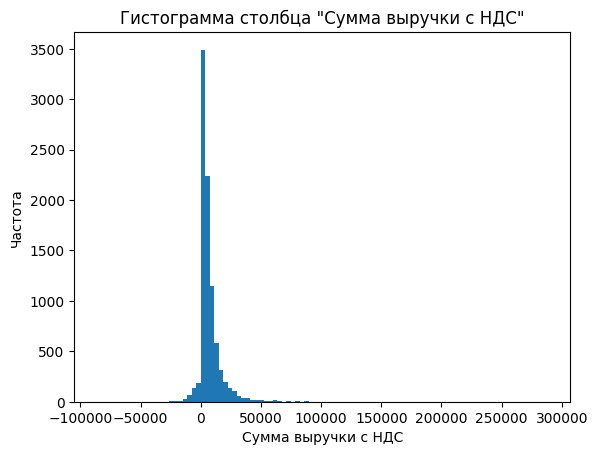

In [32]:
# Проверим столбец Сумма выручки с НДС на выбросы

plt.hist(df["Сумма выручки с НДС"], bins=100)
plt.xlabel("Сумма выручки с НДС")
plt.ylabel("Частота")
plt.title('Гистограмма столбца "Сумма выручки с НДС"')
plt.show()

В столбце с выручкой есть выбросы в районе 300000, при этом средняя сумма реализации находится в пределах 25000.

In [33]:
# Выведем статистические данные по столбцу Сумма выручки с НДС
print(df["Сумма выручки с НДС"].describe())

count      8923.000000
mean       6708.392021
std       11016.810194
min      -86315.000000
25%        1562.000000
50%        4347.000000
75%        8649.000000
max      288463.000000
Name: Сумма выручки с НДС, dtype: float64


Средняя сумма реализации - 6478, максимальная сумма возврата - 86315, максимальная сумма реализации - 288463.

#### <a id='toc1_1_3_9_'></a>[Столбец Сумма дополнительных расходов](#toc0_)

Можно предположить, что отсутсвие данных в столбце Сумма дополнительных расходов говорит о том, что они равны нулю, заменим на это значение пропуски.

In [34]:
# Заменим пропуски на значение 0
df["Сумма дополнительных расходов"].fillna(0, inplace=True)

# Поменяем формат данных на целое число
# Изменим формат данных
df["Сумма дополнительных расходов"] = df["Сумма дополнительных расходов"].astype("int")

# Проверим работу кода
print(df["Сумма дополнительных расходов"].info())

<class 'pandas.core.series.Series'>
Int64Index: 8923 entries, 0 to 9239
Series name: Сумма дополнительных расходов
Non-Null Count  Dtype
--------------  -----
8923 non-null   int32
dtypes: int32(1)
memory usage: 104.6 KB
None


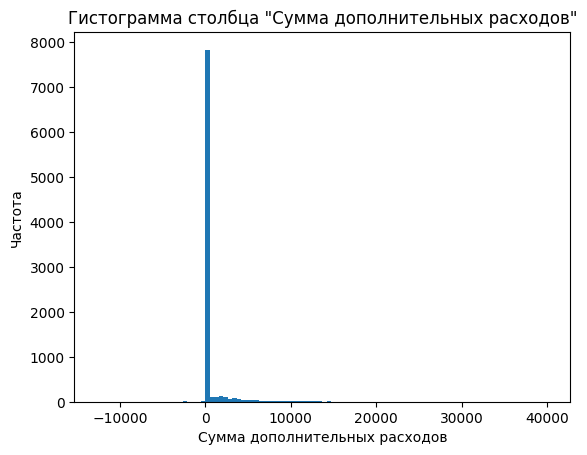

In [35]:
# Проверим столбец Сумма дополнительных расходов на выбросы

plt.hist(df["Сумма дополнительных расходов"], bins=100)
plt.xlabel("Сумма дополнительных расходов")
plt.ylabel("Частота")
plt.title('Гистограмма столбца "Сумма дополнительных расходов"')
plt.show()

В дополнительных расходах есть как положительные, так и отрицательные значения.

In [36]:
# Выведем статистические данные по столбцу Сумма дополнительных расходов
print(df["Сумма дополнительных расходов"].describe())

count     8923.000000
mean       558.337330
std       2237.585575
min     -12686.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      40103.000000
Name: Сумма дополнительных расходов, dtype: float64


В среднем на дополнительные расходы тратится 4265, максимальная сумма для дополнительных расходов равна 40103.

### <a id='toc1_1_4_'></a>[Дубликаты](#toc0_)

Проверим обработанные данные на наличие явных дубликатов.

In [37]:
print("Дубликатов в таблице", df.duplicated().sum())

Дубликатов в таблице 0


Дубликаты в данных не обнаружены. 

### <a id='toc1_1_5_'></a>[Проверка обработки данных](#toc0_)

In [95]:
# Проверим проведенную работу по всей таблице
print(df.info())
display(df.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8923 entries, 0 to 9239
Data columns (total 15 columns):
 #   Column                                                  Non-Null Count  Dtype 
---  ------                                                  --------------  ----- 
 0   Регистратор.Номер                                       8923 non-null   object
 1   Регистратор.Дата                                        8923 non-null   object
 2   Заказ клиента.Дата                                      8923 non-null   object
 3   Заказ клиента.Номер                                     8923 non-null   object
 4   Партнер.Код                                             8923 non-null   object
 5   Номенклатура.Код                                        8923 non-null   object
 6   Аналитика учета по партнерам.Партнер.Бизнес-регион      8923 non-null   object
 7   Аналитика учета по партнерам.Партнер.Отрасль            8923 non-null   object
 8   Тип запасов или услуга                          

,Регистратор.Номер,Регистратор.Дата,Заказ клиента.Дата,Заказ клиента.Номер,Партнер.Код,Номенклатура.Код,Аналитика учета по партнерам.Партнер.Бизнес-регион,Аналитика учета по партнерам.Партнер.Отрасль,Тип запасов или услуга,Хозяйственная операция,Аналитика учета номенклатуры.Номенклатура.Группа,Аналитика учета по партнерам.Партнер.Основной менеджер,Количество,Сумма выручки с НДС,Сумма дополнительных расходов
0,со-0401-001,01-04-2021,29-03-2021,со-0329-063,ут-ут000297,ут-00002777,москва(дубль),Интернет-магазин,собственный товар,реализация,плафоны st-luce,1_2 сегодина светлана,1,139,0
1,00ут-002196,01-04-2021,31-03-2021,00ут-010063,ут-ут000889,ут-00018083,самарская,unknown,собственный товар,реализация,плафоны st-luce,4_баранов михаил,1,0,0
2,00ут-002199,01-04-2021,31-03-2021,00ут-010067,00000078,00-00011710,москва(дубль),Свет магазин (специализированная розница),работа (услуга),реализация,услуги,тимченко максим,1,465,0
3,00ут-002200,01-04-2021,29-03-2021,00ут-009981,00000078,00019104,москва(дубль),Свет магазин (специализированная розница),собственный товар,реализация,st luce decorative,тимченко максим,2,6091,0
4,со-0401-002,01-04-2021,30-03-2021,со-0330-053,ут-ут002337,00018885,москва(дубль),Комплектовщик,собственный товар,реализация,evoluce актуальный ассортимент,тимченко максим,1,3966,0


#### <a id='toc1_1_5_1_'></a>[Выводы по обработке данных:](#toc0_)

- Все данные были избавлены от пропусков.
- Данные с указанием даты были изменены на формат datetime.
- Данные с количественными данными были заменены на формат целого числа int.
- Были убраны столбцы, не имеющие значения для анализа.
- Данные были проверены на дубликаты.
- Все категориальные данные были понижены в регистре, чтобы избежать проблемы неявных дубликатов.

## <a id='toc1_2_'></a>[Исследовательский анализ данных](#toc0_)

In [39]:
print("Общая сумма выручки за апрель 2021:", df["Сумма выручки с НДС"].sum())

Общая сумма выручки за апрель 2021: 59858982


In [40]:
print(
    "Топ-10 партнеров по сумме выручки:",
    df.groupby("Партнер.Код")["Сумма выручки с НДС"].sum().nlargest(10),
)

Топ-10 партнеров по сумме выручки: Партнер.Код
ут-00000011    2796487
ут-ут000841    2713736
00-00000015    2579942
ут-ут000297    2541925
00-00000115    2071363
ут-ут001622    1834571
00-00000192    1479671
цб-00001468    1168512
ут-ут000842    1045941
ут-ут000183     940867
Name: Сумма выручки с НДС, dtype: int32


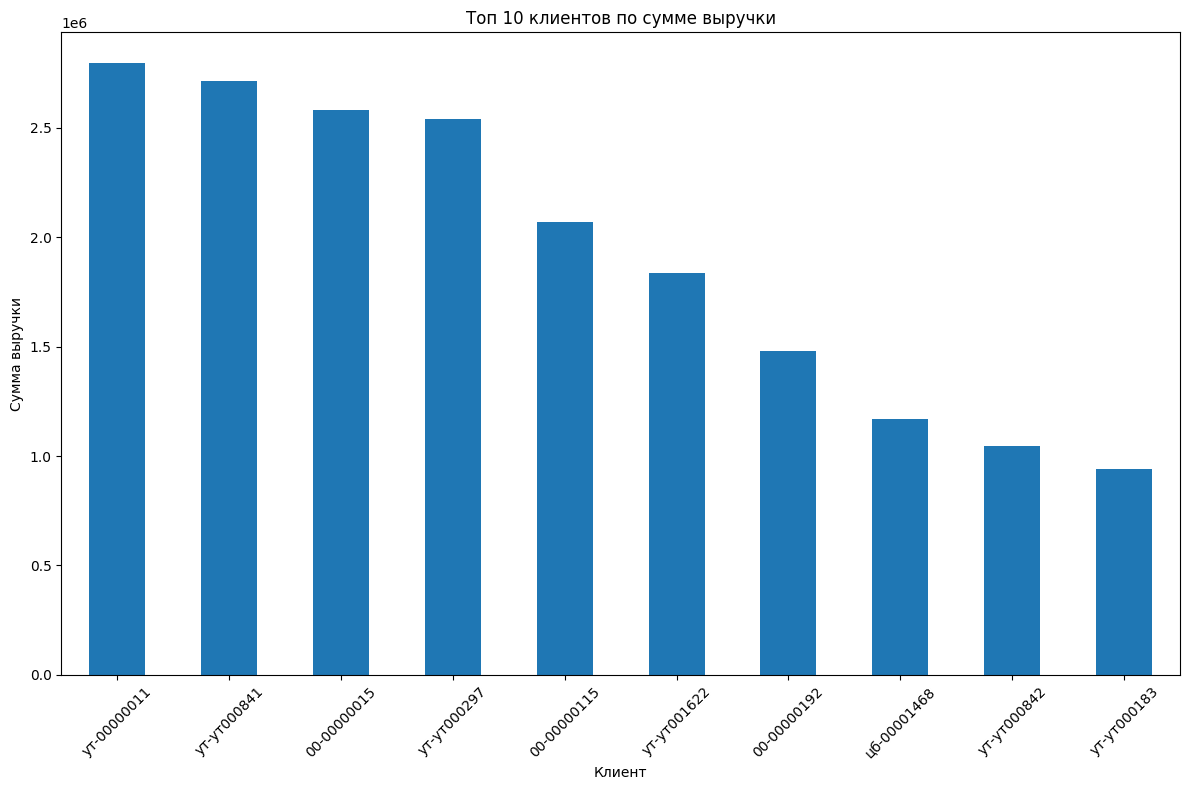

In [41]:
# Группировка по клиентам топ-10 и сумме выручки

revenue_by_client = df.groupby("Партнер.Код")["Сумма выручки с НДС"].sum()

# Сортировка суммы выручки по убыванию и выбор только топ 10
top_10_revenue_by_client = revenue_by_client.sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(12, 8))  # Изменение размеров фигуры

# Построение столбчатой диаграммы
top_10_revenue_by_client.plot(kind="bar", ax=ax)

ax.set_xlabel("Клиент")
ax.set_ylabel("Сумма выручки")
ax.set_title("Топ 10 клиентов по сумме выручки")

plt.xticks(rotation=45)  # Поворот подписей по оси X для улучшения читаемости

plt.tight_layout()  # Улучшение отображения элементов графика
plt.show()

Топ-10 клиентов покупают товара от 1 до почти 3 млн в месяц.

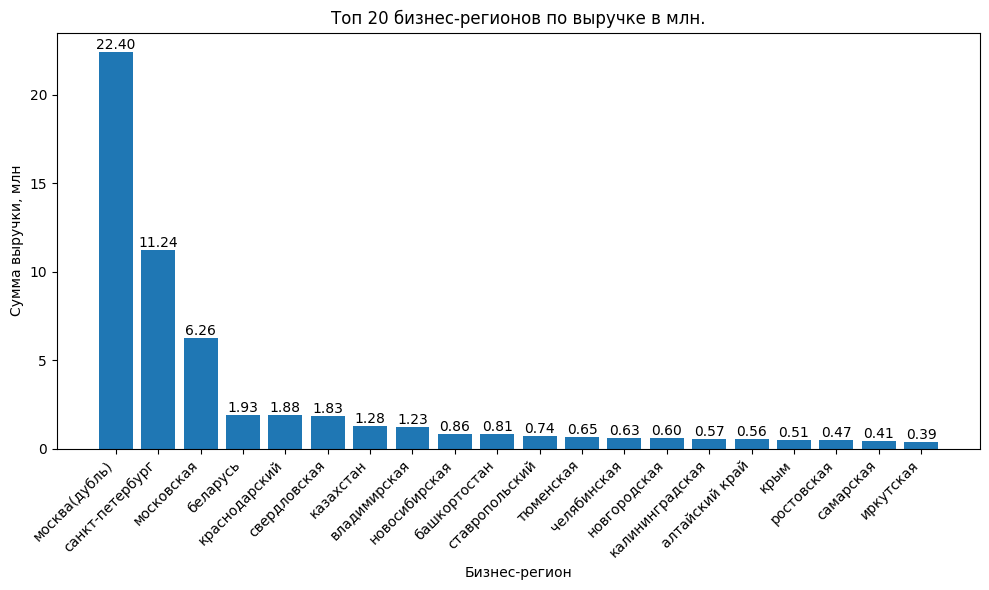

In [42]:
# Распределение выручки по бизнес-регионам партнеров

revenue_by_region = df.groupby("Аналитика учета по партнерам.Партнер.Бизнес-регион")[
    "Сумма выручки с НДС"
].sum()
top_20_regions = revenue_by_region.nlargest(20) / 1_000_000  # Сокращение до миллионов

fig, ax = plt.subplots(figsize=(10, 6))  # Изменение размеров фигуры

ax.bar(np.arange(len(top_20_regions)), top_20_regions.values)

ax.set_xticks(np.arange(len(top_20_regions)))
ax.set_xticklabels(
    top_20_regions.index, rotation=45, ha="right"
)  # Угол наклона 45 градусов
ax.set_xlabel("Бизнес-регион")
ax.set_ylabel("Сумма выручки, млн")
ax.set_title("Топ 20 бизнес-регионов по выручке в млн.")

# Добавление значений выручки над каждым столбцом (в миллионах)
for i, v in enumerate(top_20_regions.values):
    ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()  # Улучшение отображения элементов графика
plt.show()

Больше всего приносит Москва, Московская область и Санкт-Петербург. Это тройка лидеров, где Москва делает почти 50% прибыли.

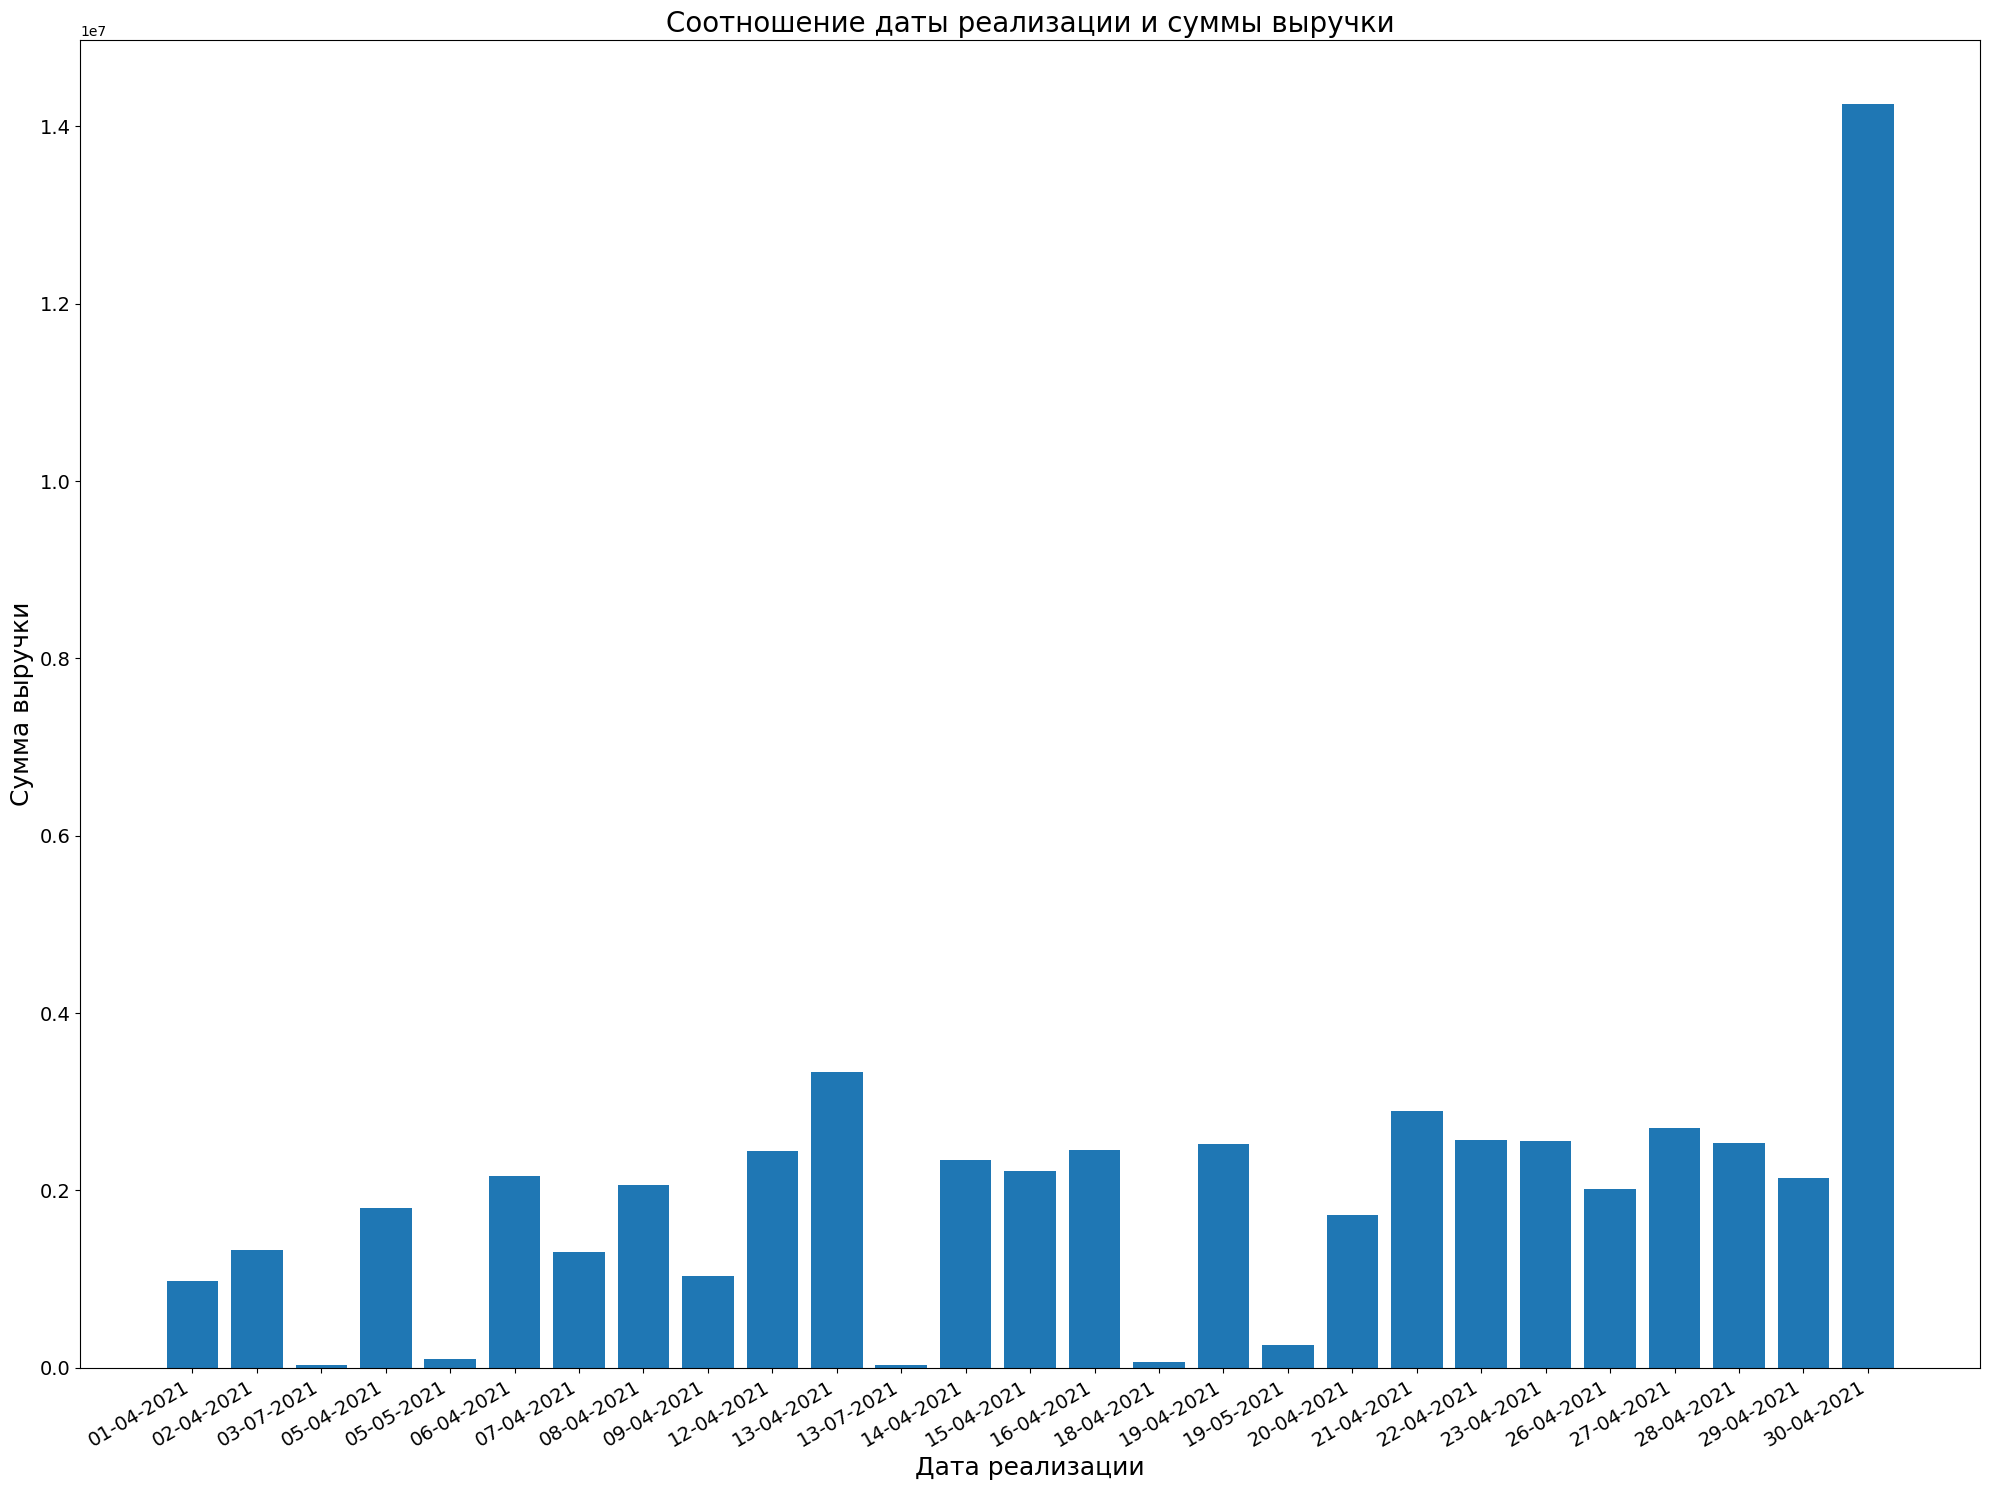

In [43]:
# Группировка по дате реализации и сумме выручки
revenue_by_date = df.groupby("Регистратор.Дата")["Сумма выручки с НДС"].sum()

fig, ax = plt.subplots(figsize=(20, 15))  # Изменение размеров фигуры

# Построение столбчатой диаграммы
ax.bar(revenue_by_date.index, revenue_by_date.values)

ax.set_xlabel("Дата реализации", fontsize=18)  # Увеличение размера текста оси X
ax.set_ylabel("Сумма выручки", fontsize=18)  # Увеличение размера текста оси Y
ax.set_title(
    "Соотношение даты реализации и суммы выручки", fontsize=20
)  # Увеличение размера текста заголовка

plt.xticks(
    rotation=45, fontsize=14
)  # Поворот и увеличение размера текста меток по оси X
plt.yticks(fontsize=14)  # Увеличение размера текста меток по оси Y

# Увеличение размера текста на делениях оси X
ax.tick_params(axis="x", which="major", labelsize=14)

# Форматирование даты на оси X
fig.autofmt_xdate()

plt.tight_layout()  # Улучшение отображения элементов графика
plt.show()

Больше всего отгруженых реализаций наблюдается в последний день апреля, обычно это связано с закрытием периода у бухгалтерии.

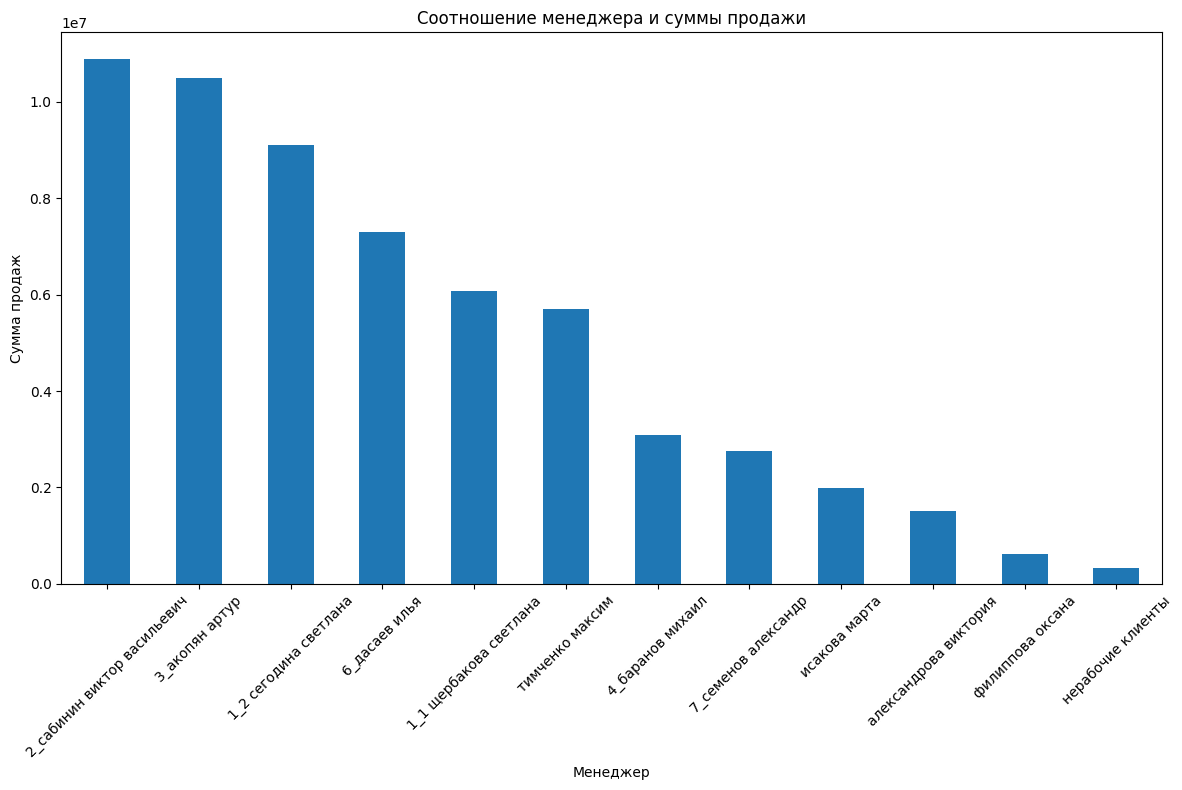

In [44]:
# Группировка по менеджерам и сумме продаж

sales_by_manager = df.groupby("Аналитика учета по партнерам.Партнер.Основной менеджер")[
    "Сумма выручки с НДС"
].sum()

# Сортировка продаж по убыванию
sales_by_manager = sales_by_manager.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))  # Изменение размеров фигуры

# Построение столбчатой диаграммы
sales_by_manager.plot(kind="bar", ax=ax)

ax.set_xlabel("Менеджер")
ax.set_ylabel("Сумма продаж")
ax.set_title("Соотношение менеджера и суммы продажи")

plt.xticks(rotation=45)  # Поворот подписей по оси X для улучшения читаемости

plt.tight_layout()  # Улучшение отображения элементов графика
plt.show()

Лучшие показатели по продажам за апрель 2021 у менеджеров:

- Сабинин Виктор,
- Акопян Артур,
- Сегодина Светлана,
- Дасаев Илья,
- Щербакова Светлана,
- Тимченко Максим

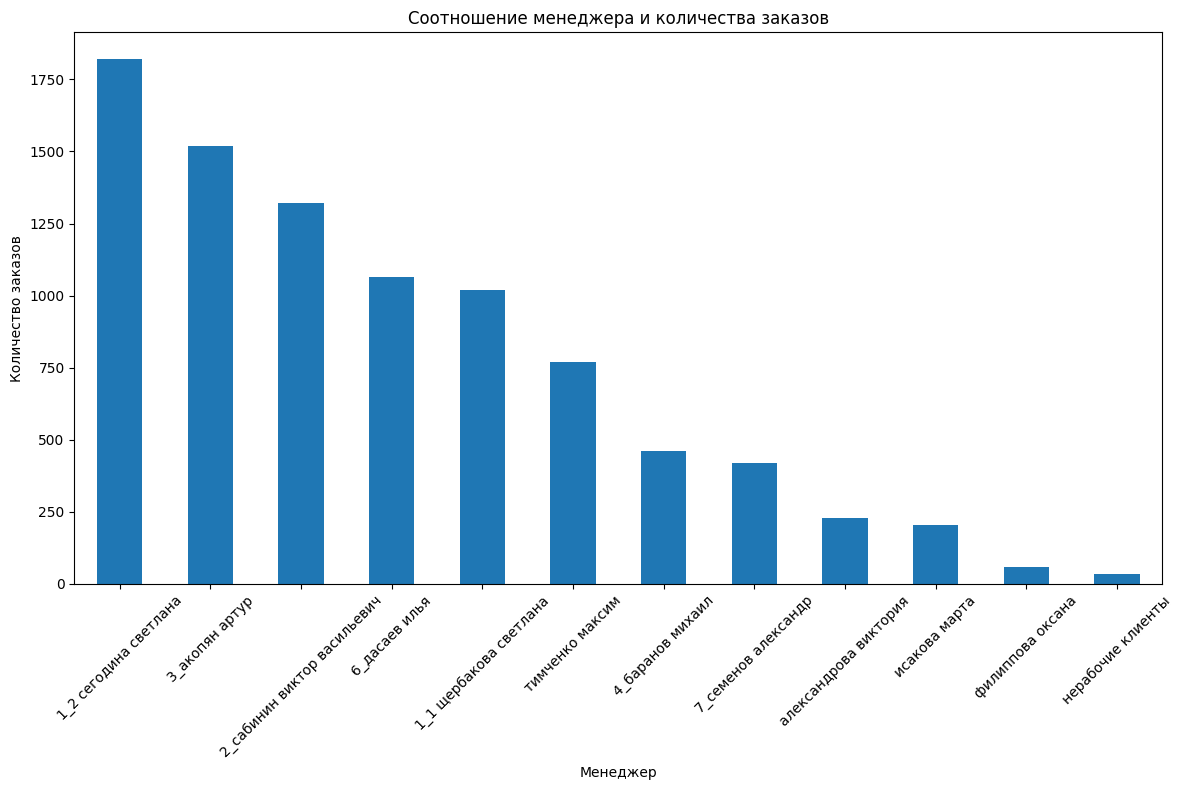

In [45]:
# Группировка по менеджерам и количеству заказов

orders_by_manager = df.groupby(
    "Аналитика учета по партнерам.Партнер.Основной менеджер"
)["Заказ клиента.Номер"].count()

# Сортировка количества заказов по убыванию
orders_by_manager = orders_by_manager.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))  # Изменение размеров фигуры

# Построение столбчатой диаграммы
orders_by_manager.plot(kind="bar", ax=ax)

ax.set_xlabel("Менеджер")
ax.set_ylabel("Количество заказов")
ax.set_title("Соотношение менеджера и количества заказов")

plt.xticks(rotation=45)  # Поворот подписей по оси X для улучшения читаемости

plt.tight_layout()  # Улучшение отображения элементов графика
plt.show()

Сегодина Светлана находится на третьем месте по продажам, но при этом делает больше всего заказов в базе.

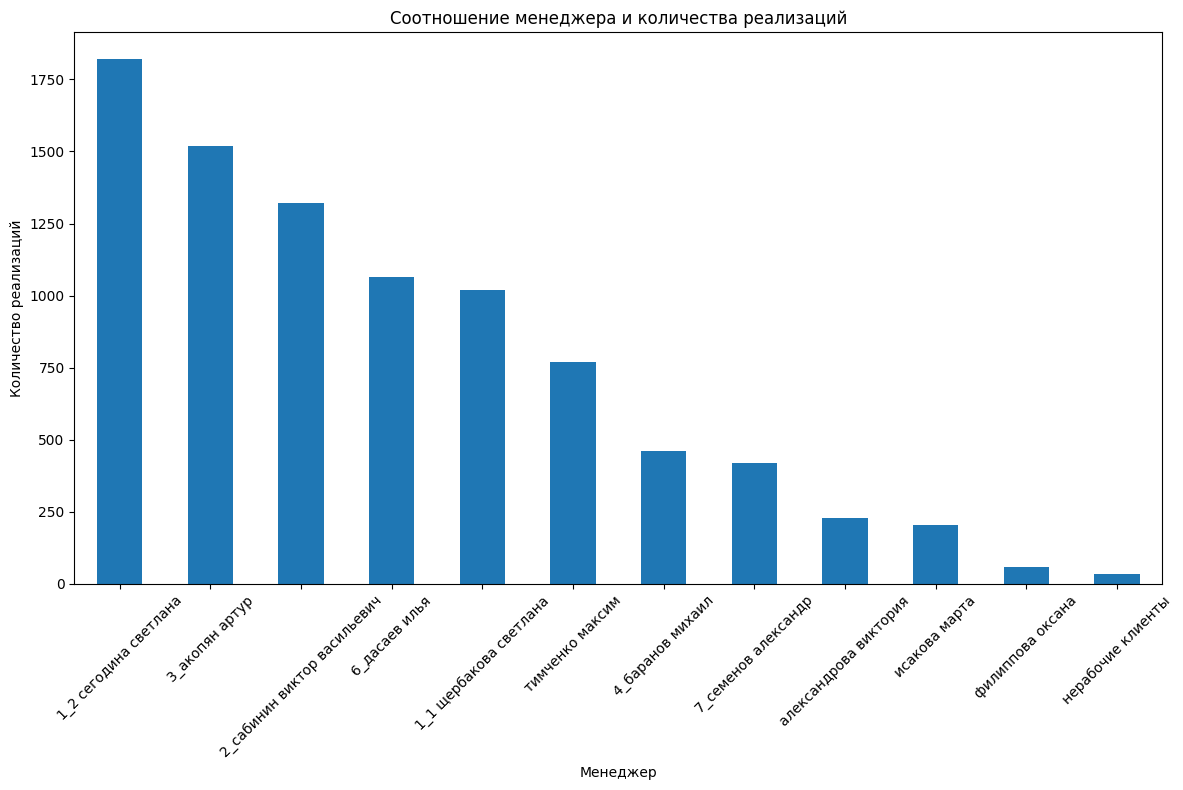

In [46]:
# Группировка по менеджерам и количеству реализаций

realizations_by_manager = df.groupby(
    "Аналитика учета по партнерам.Партнер.Основной менеджер"
)["Регистратор.Номер"].count()

# Сортировка количества реализаций по убыванию
realizations_by_manager = realizations_by_manager.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))  # Изменение размеров фигуры

# Построение столбчатой диаграммы
realizations_by_manager.plot(kind="bar", ax=ax)

ax.set_xlabel("Менеджер")
ax.set_ylabel("Количество реализаций")
ax.set_title("Соотношение менеджера и количества реализаций")

plt.xticks(rotation=45)  # Поворот подписей по оси X для улучшения читаемости

plt.tight_layout()  # Улучшение отображения элементов графика
plt.show()

Сегодина Светлана также делает больше всего реализаций, видимо ее клиенты предпочитают не самые дорогие товары.

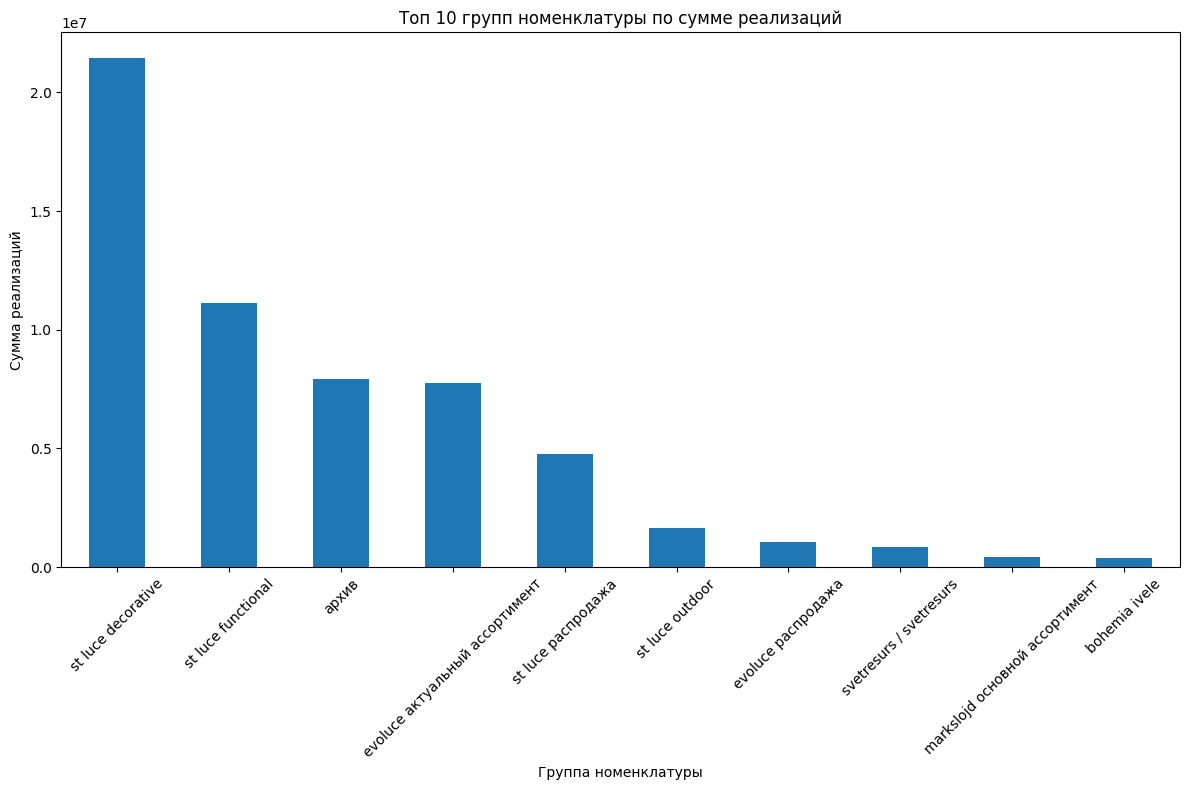

In [47]:
# Группировка по группам номенклатуры и сумме реализаций

sales_by_group = df.groupby("Аналитика учета номенклатуры.Номенклатура.Группа")[
    "Сумма выручки с НДС"
].sum()

# Сортировка суммы реализаций по убыванию и выбор только топ 10
top_20_sales_by_group = sales_by_group.sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(12, 8))  # Изменение размеров фигуры

# Построение столбчатой диаграммы
top_20_sales_by_group.plot(kind="bar", ax=ax)

ax.set_xlabel("Группа номенклатуры")
ax.set_ylabel("Сумма реализаций")
ax.set_title("Топ 10 групп номенклатуры по сумме реализаций")

plt.xticks(rotation=45)  # Поворот подписей по оси X для улучшения читаемости

plt.tight_layout()  # Улучшение отображения элементов графика
plt.show()

Больше всего из номеклатурной группы продается ST LUCE Decorative, почти в два раза меньше продается ST LUCE Functional, которому немного уступают товары из групп Архив и Ecoluce актуальный ассортимент.

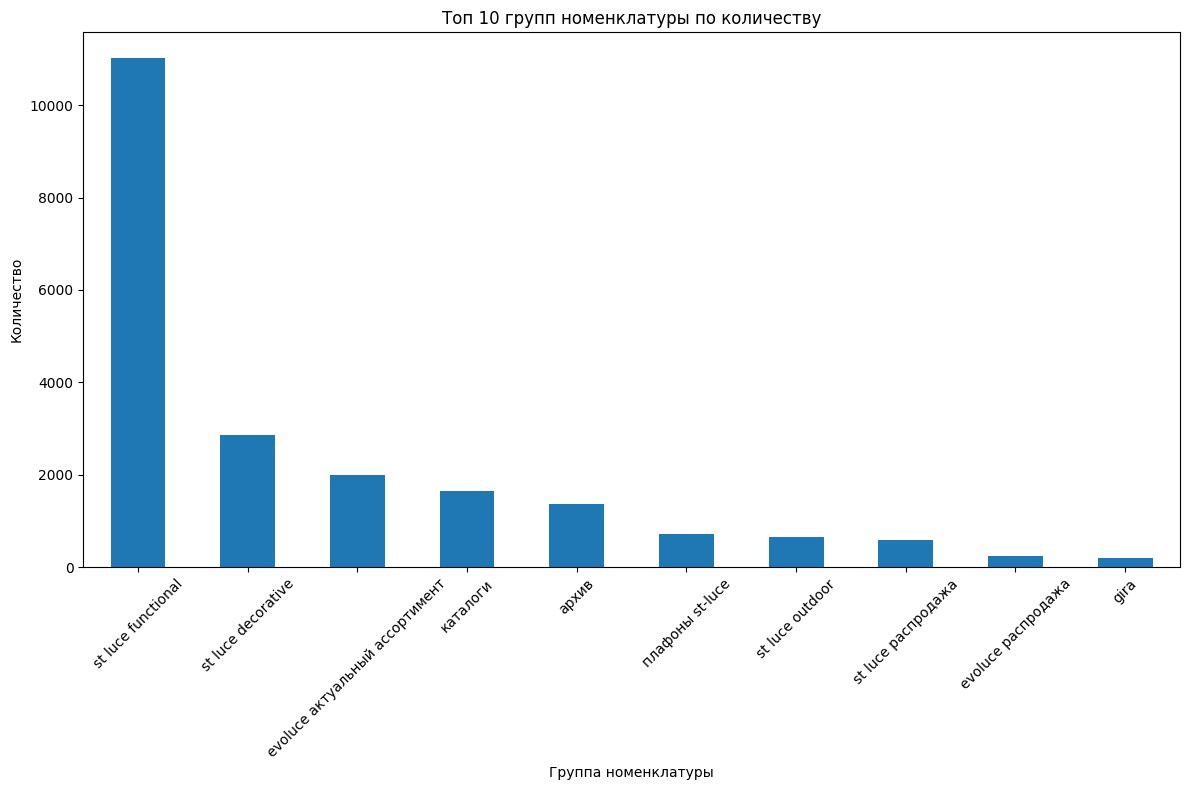

In [48]:
# Группировка по группам номенклатуры и количеству

quantity_by_group = df.groupby("Аналитика учета номенклатуры.Номенклатура.Группа")[
    "Количество"
].sum()

# Сортировка количества по убыванию и выбор только топ 10
top_10_quantity_by_group = quantity_by_group.sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(12, 8))  # Изменение размеров фигуры

# Построение столбчатой диаграммы
top_10_quantity_by_group.plot(kind="bar", ax=ax)

ax.set_xlabel("Группа номенклатуры")
ax.set_ylabel("Количество")
ax.set_title("Топ 10 групп номенклатуры по количеству")

plt.xticks(rotation=45)  # Поворот подписей по оси X для улучшения читаемости

plt.tight_layout()  # Улучшение отображения элементов графика
plt.show()

Со значительным отрывом продается товар из группы ST LUCE Functional - около 12 тысяч штук в месяц. При этом гораздо более прибыльная группа ST LUCE Decirative продается в размере 3 тысяч штук за тот же период.

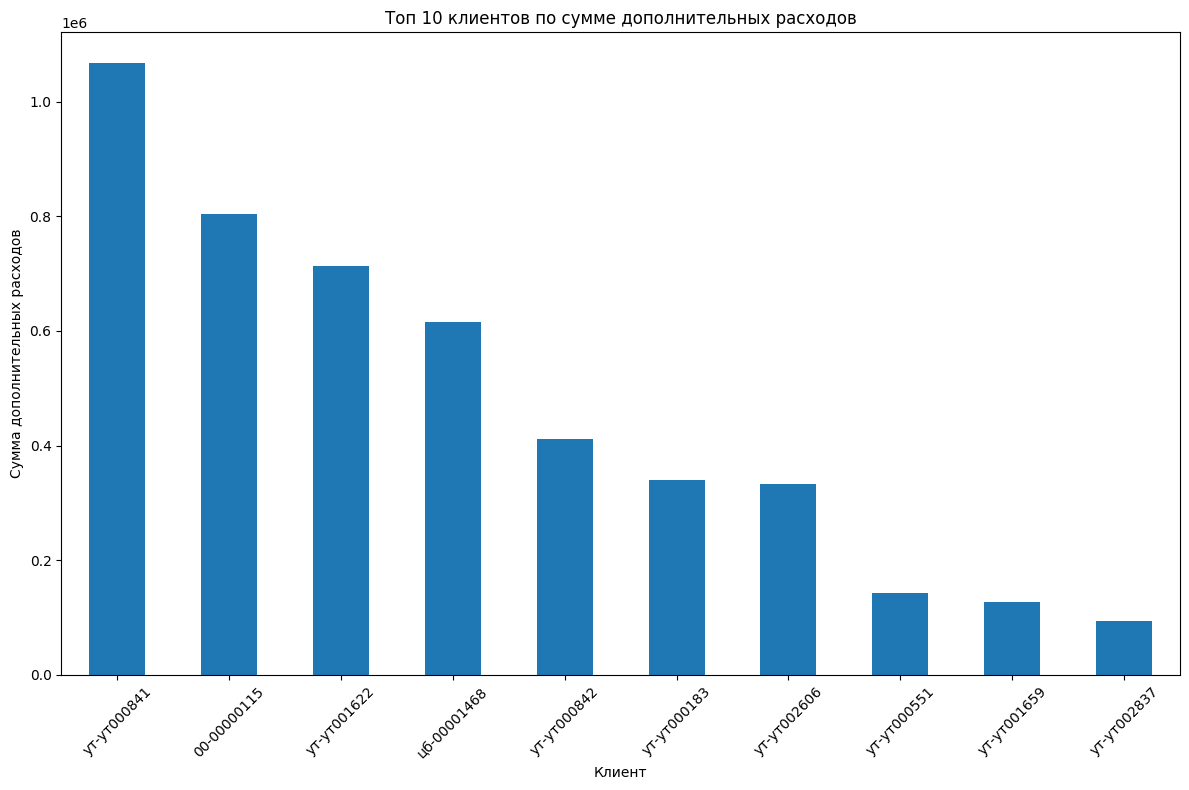

In [49]:
# Группировка по клиентам и сумме дополнительных расходов

expenses_by_client = df.groupby("Партнер.Код")["Сумма дополнительных расходов"].sum()

# Сортировка суммы дополнительных расходов по убыванию и выбор только топ 10
top_10_expenses_by_client = expenses_by_client.sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(12, 8))  # Изменение размеров фигуры

# Построение столбчатой диаграммы
top_10_expenses_by_client.plot(kind="bar", ax=ax)

ax.set_xlabel("Клиент")
ax.set_ylabel("Сумма дополнительных расходов")
ax.set_title("Топ 10 клиентов по сумме дополнительных расходов")

plt.xticks(rotation=45)  # Поворот подписей по оси X для улучшения читаемости

plt.tight_layout()  # Улучшение отображения элементов графика
plt.show()

Больше миллиона рублей дополнительных расходов было выделено для клиента УТ-УТ000841. Восемьсот тысяч также было выделено для клиента 00-00000115 и около 780 тысяч для клиента УТ-УТ001622.

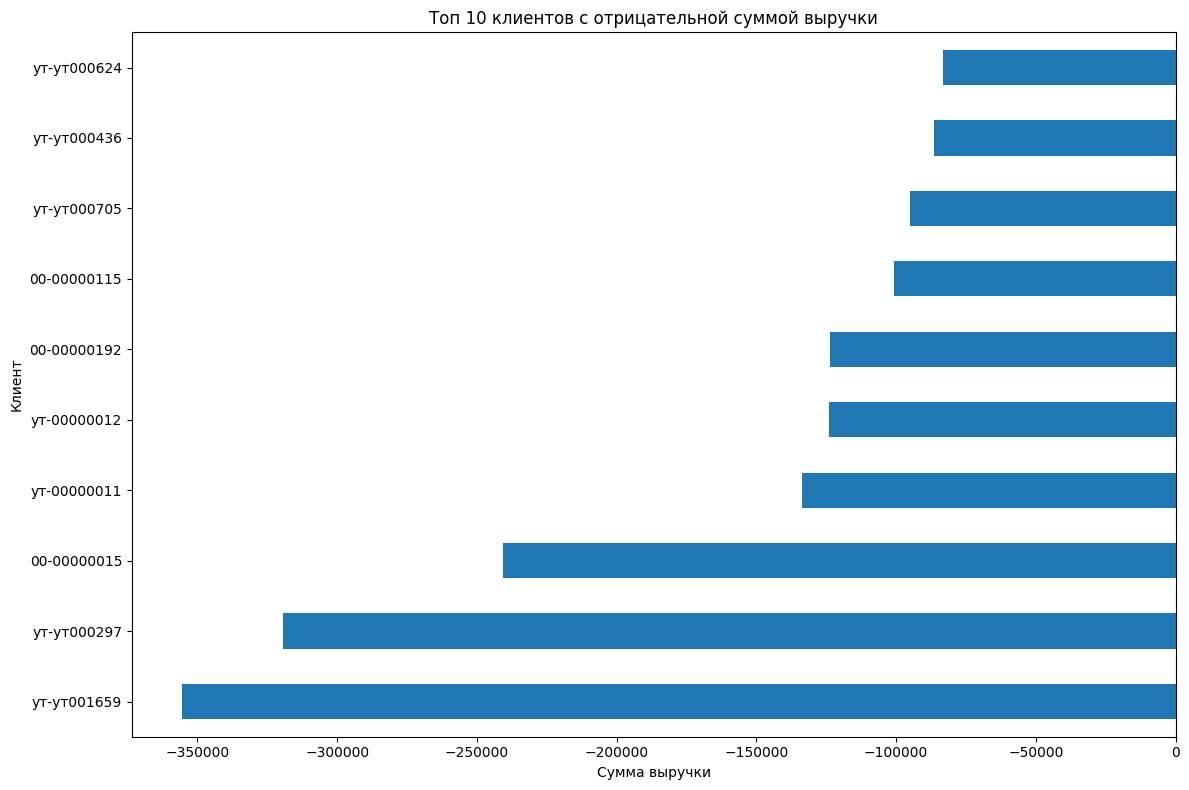

In [50]:
# Отбор клиентов с отрицательной суммой выручки

negative_revenue_clients = df[df["Сумма выручки с НДС"] < 0]

# Группировка по клиентам и сумме отрицательной выручки
negative_revenue_by_client = negative_revenue_clients.groupby("Партнер.Код")[
    "Сумма выручки с НДС"
].sum()

# Сортировка суммы отрицательной выручки по количеству и выбор только топ 10
top_10_negative_revenue_by_client = negative_revenue_by_client.sort_values().head(10)

fig, ax = plt.subplots(figsize=(12, 8))  # Изменение размеров фигуры

# Построение столбчатой диаграммы
top_10_negative_revenue_by_client.plot(kind="barh", ax=ax)

ax.set_xlabel("Сумма выручки")
ax.set_ylabel("Клиент")
ax.set_title("Топ 10 клиентов с отрицательной суммой выручки")

plt.tight_layout()  # Улучшение отображения элементов графика
plt.show()

Почти на 350 тысяч вернул товара клиент УТ-УТ001659, около 310 тысяч с обратной реализацией было у клиента УТ-УТ001659. На третьем месте находится клиент 00-00000015 с суммой возвратов чуть меньше 250 тысяч.

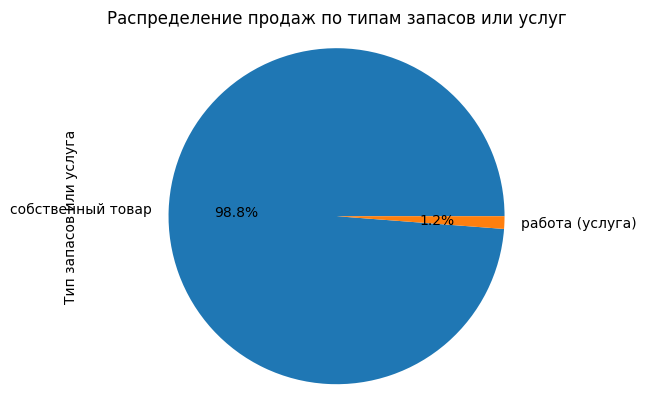

In [51]:
# Количество продаж по типам запасов или услугам

sales_by_product_type = df["Тип запасов или услуга"].value_counts()
sales_by_product_type.plot(kind="pie", autopct="%1.1f%%")
plt.axis("equal")
plt.title("Распределение продаж по типам запасов или услуг")
plt.show()

Больше всего клиенты предпочитают приобретать товар, но есть один процент клиентов, которые пользуются услугами компании.

### <a id='toc1_2_1_'></a>[Выводы по статистическому анализу](#toc0_)

- Были определены топ-10 лучших клиентов по сумме выручки.
- Был составлен рейтинг самых прибыльных регионов.
- Был определен рейтинг самых прибыльных и продуктивных менеджеров по продажам.
- Был создан график по отношению суммы реализаций к дате.
- Определены самые продаваемые номенклатурные группы в размере прибыли и количестве проданного товара.
- Были определены клиенты, на которых выделяются дополнительные расходы.
- Также были определены клиенты, которые совершают возвраты на самые крупные суммы.
- Был создан график по распределению продаж по типам запасов и услуг.

### <a id='toc1_2_2_'></a>[Мультиколлинеарность](#toc0_)

Мультиколлинеарность - это статистический термин, который описывает сильную линейную зависимость между двумя или более объясняющими переменными (факторами) в модели. Другими словами, когда две или более переменные в модели сильно связаны между собой, можно предсказать одну переменную с помощью другой или комбинации других переменных.

Это может стать проблемой при построении моделей, потому что мультиколлинеарность может усложнить интерпретацию результатов и искажать влияние каждой переменной на целевую переменную. Когда переменные сильно связаны между собой, это может приводить к нестабильным и непредсказуемым оценкам коэффициентов модели.

Мультиколлинеарность может быть обнаружена с помощью различных статистических методов и показателей, таких как матрица корреляции или коэффициенты корреляции между переменными. Если обнаружена мультиколлинеарность, возможными способами решения проблемы являются удаление одной или нескольких связанных переменных, объединение переменных или использование методов регуляризации.

Важно знать о наличии мультиколлинеарности в модели, чтобы принять соответствующие меры для улучшения качества модели и интерпретации ее результатов.

Мультиколлинеарность, как и корреляция - это рассчетные показатели, соответственно им требуется, чтобы все признаки (переменные) были в формате цифр, но мы обойдем эту условность, используя библиотеку Phik, которая умеет работать с категориальными признаками.

In [52]:
phik_overview = df.phik_matrix()
phik_overview.round(2)


interval columns not set, guessing: ['Количество', 'Сумма выручки с НДС', 'Сумма дополнительных расходов']


,Регистратор.Номер,Регистратор.Дата,Заказ клиента.Дата,Заказ клиента.Номер,Партнер.Код,Номенклатура.Код,Аналитика учета по партнерам.Партнер.Бизнес-регион,Аналитика учета по партнерам.Партнер.Отрасль,Тип запасов или услуга,Хозяйственная операция,Аналитика учета номенклатуры.Номенклатура.Группа,Аналитика учета по партнерам.Партнер.Основной менеджер,Количество,Сумма выручки с НДС,Сумма дополнительных расходов
Регистратор.Номер,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,0.86,0.99,1.00,0.80,0.87,0.00
Регистратор.Дата,1.00,1.00,0.93,0.99,0.96,0.67,0.78,0.48,0.06,0.70,0.62,0.71,0.07,0.12,0.54
Заказ клиента.Дата,1.00,0.93,1.00,1.00,0.99,1.00,0.91,0.69,0.00,0.86,0.62,0.69,0.00,0.34,0.44
Заказ клиента.Номер,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.86,0.98,1.00,0.87,0.92,0.00
Партнер.Код,1.00,0.96,0.99,1.00,1.00,0.00,1.00,1.00,0.49,0.76,0.97,1.00,0.55,0.71,0.00
Номенклатура.Код,0.00,0.67,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.57,1.00,0.74,0.00,0.86,0.89
Аналитика учета по партнерам.Партнер.Бизнес-регион,1.00,0.78,0.91,1.00,1.00,0.00,1.00,0.81,0.10,0.63,0.56,0.94,0.24,0.15,0.38
Аналитика учета по партнерам.Партнер.Отрасль,1.00,0.48,0.69,1.00,1.00,0.00,0.81,1.00,0.09,0.42,0.21,0.82,0.00,0.00,0.25
Тип запасов или услуга,1.00,0.06,0.00,1.00,0.49,1.00,0.10,0.09,1.00,0.04,1.00,0.23,0.00,0.00,0.00
Хозяйственная операция,0.86,0.70,0.86,0.86,0.76,0.57,0.63,0.42,0.04,1.00,0.27,0.61,0.17,0.31,0.67


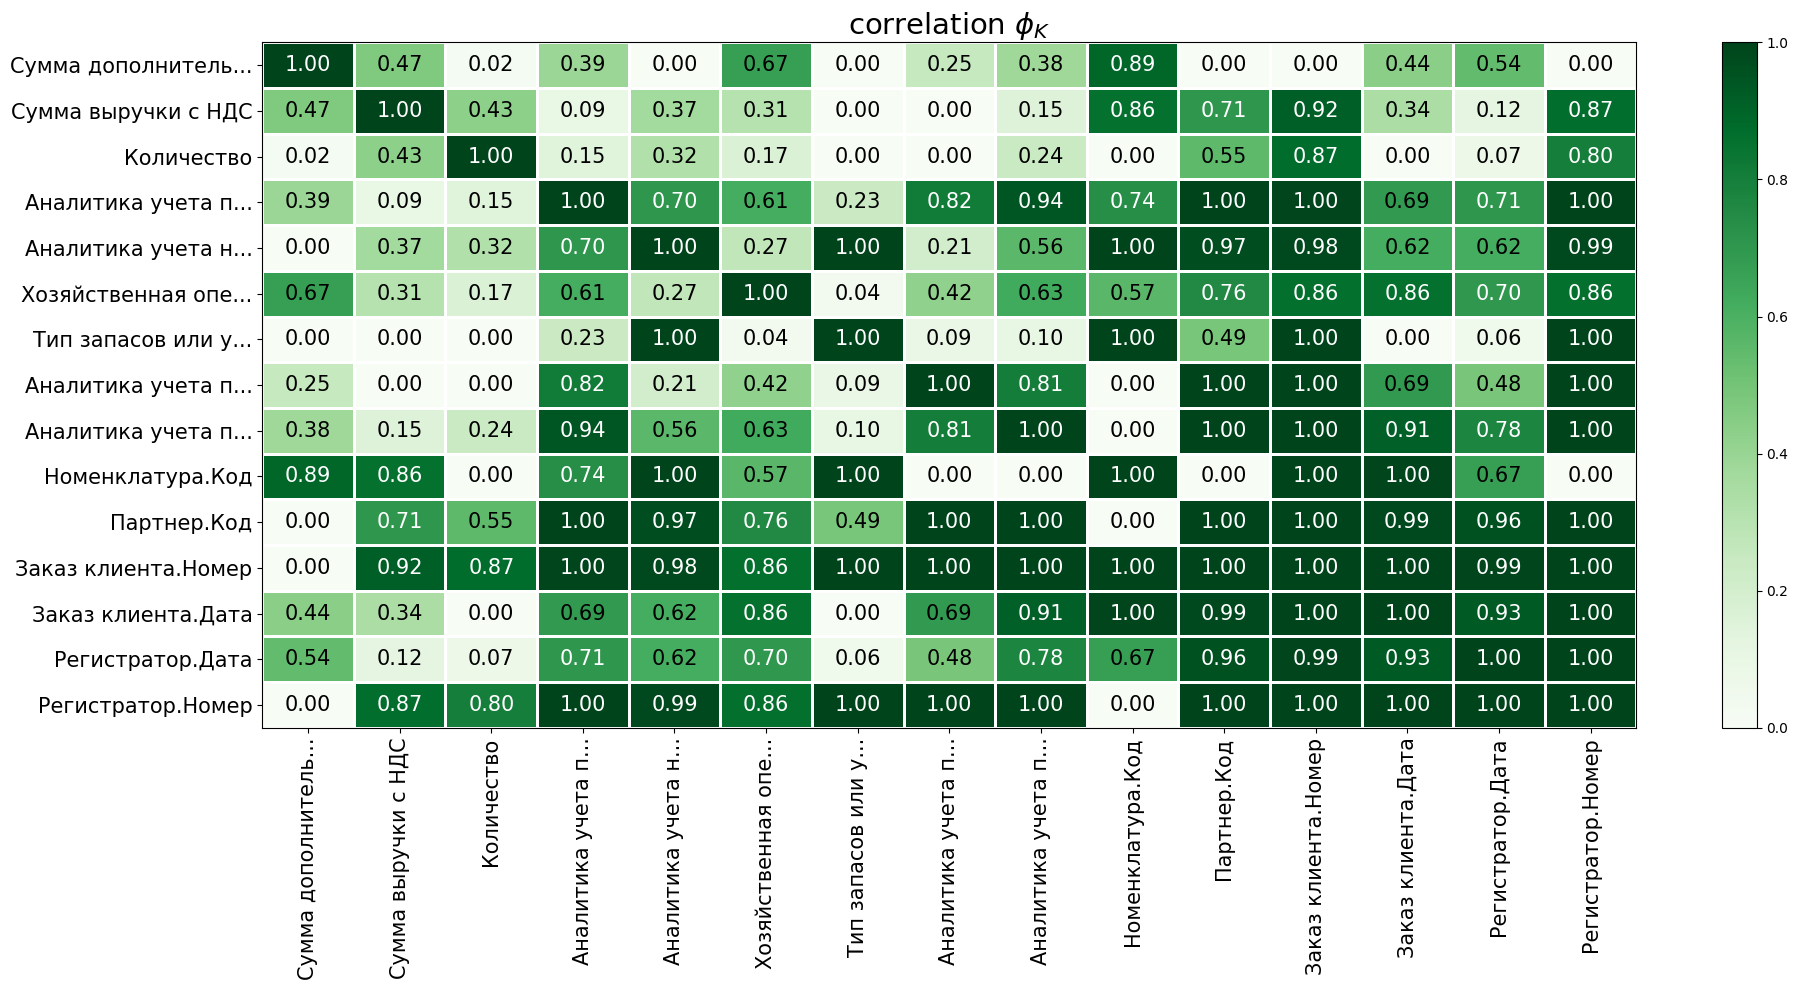

In [53]:
# Создадим тепловую карту на основе библиотеки Phik
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map="Greens",
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(20, 10),
)
plt.tight_layout()

Используя данную карту, мы можем определить как соотносятся данные в датасете:

- Наш целевой столбец Сумма выручки с НДС имеет высокую корреляцию с кодом номенклатуры, номером заказа и номером реализации, но при этом нигде не достигает единицы, что дает предположить, что проблемы переобучения не возникнет, иначе эти столбцы нужно будет переделать или удалить.
- Столбец Номер заказа имеет высокую коллинеарность почти по всеми столбцами и во многих случаях достигает единицы. В случае переобучения этот столбец нужно будет удалить первым.
- Также высокая корреляция наблюдается у столбца с номером реализации.

Возможно предположить, что так как каждый номер заказа и реализации уникальны, эти столбцы имеют большую связь со всеми остальными столбцами, как бы предсказывая их значение.

## <a id='toc1_3_'></a>[Обучение моделей](#toc0_)

### <a id='toc1_3_1_'></a>[Разбивка датасетов на тренировочную и тестовую выборки](#toc0_)

In [71]:
# Выведем названия столбцов

df.columns


Index(['Регистратор.Номер', 'Регистратор.Дата', 'Заказ клиента.Дата',
       'Заказ клиента.Номер', 'Партнер.Код', 'Номенклатура.Код',
       'Аналитика учета по партнерам.Партнер.Бизнес-регион',
       'Аналитика учета по партнерам.Партнер.Отрасль',
       'Тип запасов или услуга', 'Хозяйственная операция',
       'Аналитика учета номенклатуры.Номенклатура.Группа',
       'Аналитика учета по партнерам.Партнер.Основной менеджер', 'Количество',
       'Сумма выручки с НДС', 'Сумма дополнительных расходов'],
      dtype='object')

Выделяем отдельно целевой столбец, и убираем столбцы, которые были использованы для исследовательского анализа и могут повлиять на работу моделей. Убираем также даты, так как мы не делаем анализ временных рядов.

In [72]:
target = df["Сумма выручки с НДС"]

features = df.drop(
    ["Сумма выручки с НДС", "Регистратор.Дата", "Заказ клиента.Дата"], axis=1
)

# Проверим работу кода
print("Размер признаков:", features.shape)
print("Размер целевого признака:", target.shape)

Размер признаков: (8923, 12)
Размер целевого признака: (8923,)


Данные распределились ровно.

In [73]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

In [74]:
# проверка размера тренировочной и тестовой выборок
print(
    "Размер тренировочной выборки:",
    features_train.shape,
    "Размер целевого признака:",
    target_train.shape,
)

Размер тренировочной выборки: (6692, 12) Размер целевого признака: (6692,)


### <a id='toc1_3_2_'></a>[Построение моделей](#toc0_)

Один из способов оценить, насколько хорошо регрессионная модель соответствует набору данных, — вычислить среднеквадратичную ошибку (или RMSE - Root Mean Square Error), которая сообщает нам среднее расстояние между прогнозируемыми значениями из модели и фактическими значениями в наборе данных.

Формула для нахождения среднеквадратичной ошибки, часто обозначаемая аббревиатурой RMSE , выглядит следующим образом:

СКО = √ Σ(P i – O i ) 2 / n

где:

Σ — символ, означающий «сумма».
P i - прогнозируемое значение для i -го наблюдения в наборе данных.
O i - наблюдаемое значение для i -го наблюдения в наборе данных.
n - размер выборки

Чем ниже RMSE, тем лучше данная модель может «соответствовать» набору данных. Однако диапазон набора данных, с которым вы работаете, важен для определения того, является ли заданное значение RMSE «низким» или нет.

Например, рассмотрим следующие сценарии:

Сценарий 1: Мы хотели бы использовать регрессионную модель для прогнозирования цен на дома в определенном городе. Предположим, что модель имеет значение RMSE, равное 500 долларов. Поскольку типичный диапазон цен на дома составляет от 70 000 до 300 000 долларов, это значение RMSE чрезвычайно низкое. Это говорит нам о том, что модель способна точно предсказывать цены на жилье.

Сценарий 2. Теперь предположим, что мы хотим использовать регрессионную модель, чтобы предсказать, сколько человек будет тратить в месяц в определенном городе. Предположим, что модель имеет значение RMSE, равное 500 долларов. Если типичный диапазон ежемесячных расходов составляет от 1500 до 4000 долларов США, это значение RMSE довольно велико. Это говорит нам о том, что модель не может очень точно прогнозировать ежемесячные расходы.

В нашем случае мы рассматриваем реализации с размером от min -86315.00 до max 288463.00, то есть большой разброс значений с наличием аномалий.

#### <a id='toc1_3_2_1_'></a>[Линейная регрессия](#toc0_)

In [75]:
# Выделяем цифровые и категориальные признаки
num_cols = make_column_selector(dtype_include=np.number)(features_train)
cat_cols = make_column_selector(dtype_include=object)(features_train)


In [81]:
# Создаем препроцессор
lr_preprocessor = ColumnTransformer(
    transformers=[
        ("scaling", StandardScaler(), num_cols)
        # ("cat", OneHotEncoder(drop='first'), cat_cols)
    ]
)

# Создаем пайплайн
lr_pipe = Pipeline(
    [("preprocessor", lr_preprocessor), ("regressor", LinearRegression())]
)

# Определяем гиперпараметры для линейной регрессии
lr_param_grid = {"regressor__normalize": [True, False]}

# Создаем грид-серч
lr_grid_search = GridSearchCV(
    lr_pipe, lr_param_grid, cv=5, n_jobs=-1, scoring="neg_root_mean_squared_error"
)

# Обучаем грид-серч на тренировочной выборке
lr_grid_search.fit(features_train, target_train)

print("Лучшие параметры для Линейной Регрессии:", lr_grid_search.best_params_)
print("Лучший эстиматор для Линейной Регрессии:", lr_grid_search.best_estimator_)
print("Лучший результат для Линейной Регрессии:", -lr_grid_search.best_score_)

Лучшие параметры для Линейной Регрессии: {'regressor__normalize': True}
Лучший эстиматор для Линейной Регрессии: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                                  ['Количество',
                                                   'Сумма дополнительных '
                                                   'расходов'])])),
                ('regressor', LinearRegression(normalize=True))])
Лучший результат для Линейной Регрессии: 9876.903011423714


#### <a id='toc1_3_2_2_'></a>[Случайный лес](#toc0_)

In [82]:
# Создаем препроцессор
rf_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols)
        # ("cat", OrdinalEncoder(), cat_cols)
    ]
)

# создаем пайплайн
rf_pipeline = Pipeline(
    [
        ("preprocessor", rf_preprocessor),
        ("model", RandomForestRegressor(random_state=RANDOM_STATE)),
    ]
)

# Определяем  гиперпараметры для Случайного леса
rf_param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4],
}

# Создаем грид-серч
rf_grid_search = GridSearchCV(
    rf_pipeline, rf_param_grid, cv=5, n_jobs=-1, scoring="neg_root_mean_squared_error"
)

# Обучаем грид-серч на тренировочной выборке
rf_grid_search.fit(features_train, target_train)

print("Лучшие параметры для Случайного леса", rf_grid_search.best_params_)
print("Лучший эстиматор для Случайного леса", rf_grid_search.best_estimator_)
print("Лучший результат для Случайного леса", -rf_grid_search.best_score_)

Лучшие параметры для Случайного леса {'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__n_estimators': 300}
Лучший эстиматор для Случайного леса Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Количество',
                                                   'Сумма дополнительных '
                                                   'расходов'])])),
                ('model',
                 RandomForestRegressor(max_depth=5, min_samples_leaf=4,
                                       n_estimators=300, random_state=42))])
Лучший результат для Случайного леса 9543.428503907418


#### <a id='toc1_3_2_3_'></a>[Категориальный бустинг](#toc0_)

In [86]:
# Категориальный бустинг

cat_features = cat_cols

cb_pipe = Pipeline(
    [
        (
            "regressor",
            CatBoostRegressor(cat_features=cat_features, random_state=RANDOM_STATE),
        )
    ]
)

cb_param_grid = {
    "regressor__iterations": [50, 100, 150],
    "regressor__depth": [3, 4, 5, 10],
    "regressor__learning_rate": [0.01, 0.05, 0.1],
}

cb_grid_search = GridSearchCV(
    cb_pipe,
    cb_param_grid,
    cv=5,
    verbose=1,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)
cb_grid_search.fit(features_train, target_train)

print("Лучшие параметры для Категориального бустинга", cb_grid_search.best_params_)
print("Лучший эстиматор для Категориального бустинга", cb_grid_search.best_estimator_)
print("Лучший результат для Категориального бустинга", -cb_grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	learn: 10851.4042844	total: 80.3ms	remaining: 12s
1:	learn: 10587.3144971	total: 140ms	remaining: 10.4s
2:	learn: 10340.0546492	total: 202ms	remaining: 9.87s
3:	learn: 10116.0492233	total: 268ms	remaining: 9.77s
4:	learn: 9929.0447145	total: 338ms	remaining: 9.8s
5:	learn: 9767.6596400	total: 409ms	remaining: 9.81s
6:	learn: 9609.7915070	total: 504ms	remaining: 10.3s
7:	learn: 9519.5357949	total: 574ms	remaining: 10.2s
8:	learn: 9397.9286343	total: 645ms	remaining: 10.1s
9:	learn: 9294.1729954	total: 715ms	remaining: 10s
10:	learn: 9205.8295291	total: 778ms	remaining: 9.83s
11:	learn: 9144.2787310	total: 846ms	remaining: 9.73s
12:	learn: 9070.7269122	total: 910ms	remaining: 9.59s
13:	learn: 9003.5939825	total: 968ms	remaining: 9.41s
14:	learn: 8934.5557139	total: 1.03s	remaining: 9.27s
15:	learn: 8860.1906250	total: 1.09s	remaining: 9.14s
16:	learn: 8773.6171338	total: 1.15s	remaining: 9.02s
17:	learn: 8693.5019537	total:

#### <a id='toc1_3_2_4_'></a>[LightGBM](#toc0_)

In [84]:
for c in cat_cols:
    features_train[c] = features_train[c].astype("category")

numerical_transformer = StandardScaler()


preprocessor = ColumnTransformer(
    transformers=[("num", numerical_transformer, num_cols)]
)


lgbm = LGBMRegressor(random_state=RANDOM_STATE)


lgbm_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("lgbm", lgbm)])


lgbm_param_grid = {
    "lgbm__n_estimators": [100, 500, 1000],
    "lgbm__learning_rate": [0.01, 0.1, 0.5],
    "lgbm__num_leaves": [31, 63, 127],
    "lgbm__max_depth": [3, 6, 9],
}

lgbm_grid_search = GridSearchCV(
    lgbm_pipeline,
    lgbm_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="neg_root_mean_squared_error",
)
lgbm_grid_search.fit(features_train, target_train)


print("Лучшие параметры для LightGBM", lgbm_grid_search.best_params_)
print("Лучший эстиматор для LightGBM", lgbm_grid_search.best_estimator_)
print("Лучший результат для LightGBM", -lgbm_grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Лучшие параметры для LightGBM {'lgbm__learning_rate': 0.01, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 500, 'lgbm__num_leaves': 31}
Лучший эстиматор для LightGBM Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Количество',
                                                   'Сумма дополнительных '
                                                   'расходов'])])),
                ('lgbm',
                 LGBMRegressor(learning_rate=0.01, max_depth=3,
                               n_estimators=500, random_state=42))])
Лучший результат для LightGBM 9537.847878763127


| Модель   | Значение RMSE            | | Подобранные гиперпараметры                                          |
|----------|-------------------------|-------------------------|---------------------------------------------|
| LR       | RMSE: 9876.90 | | 'regressor__normalize': True |
| RF       | RMSE: 9543.42 | | 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__n_estimators': 300 |
| CatB     | RMSE: 8093.37| | 'regressor__depth': 5, 'regressor__iterations': 150, 'regressor__learning_rate': 0.1|
| LGBM     | RMSE: 9537.84 | | 'lgbm__learning_rate': 0.01, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 500, 'lgbm__num_leaves': 31|

Лучшие результат на тренировочной выборке достигнут на модели CatBoost.

### <a id='toc1_3_3_'></a>[Тестирование модели](#toc0_)

#### <a id='toc1_3_3_1_'></a>[CatBoostRegressor](#toc0_)

In [94]:
# Получение лучшей модели из грид-серча
best_cb_model = cb_grid_search.best_estimator_

# Прогнозирование на тестовых данных
cb_predictions = best_cb_model.predict(features_test)

# Вычисление метрик на тестовых данных
mse = mean_squared_error(target_test, cb_predictions)
rmse = np.sqrt(mse)


print("RMSE на тестовых данных:", rmse)

RMSE на тестовых данных: 7352.225137444326


На тестовых данных удалось улучшить результат и снизить показатель ошибки RMSE.

In [92]:
# Сохраним результаты прогноза в отдельный Excel-файл

output = pd.DataFrame(
    {
        "Код клиента": features_test["Партнер.Код"],
        "Факт продажи": target_test,
        "Прогноз продажи": cb_predictions,
    }
)
output.to_excel("Прогноз продаж.xlsx", index=False)
print("Задача выполнена!")

Задача выполнена!


## <a id='toc1_4_'></a>[Вывод](#toc0_)

Целью данного проекта был анализ продаж на основе полученных данных с построением графиков.

Чтобы улучшить результаты анализа, я также добавил четыре модели машинного обучения для прогноза продаж на следующий месяц (соответственно май 2021).

По правильному, нужно было объединить всех клиентов в группы, а не рассматривать отдельно каждую реализацию, но на основе Центральной Предельной Теоремы, для построения моделей требуется много данных (минимум 10000, а желательно от 100000 строк в таблице).

Я мог искусственно увеличить общий датасет, используя технологию Бутстреп, которая рандомно генерирует схожие выборки, но при этом среднее значение и дисперсия сохраняются, при этом дисперсия может даже уменьшиться. Но для бутстрепа требуются значительные вычислительные мощности и тогда бы выполнение тестового задания заняло гораздо больше времени, если делать его на домашнем компьютере.

Результаты прогнозов продаж сохранены отдельным Excel-файлом.